# Initialize notebook

In [1]:
# Import libraries
import math
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import mean_squared_error
import time
from operator import is_not
from functools import partial
import statistics
from tqdm import tqdm
from scipy.optimize import curve_fit
import pickle

In [2]:
# Constants
#KITTI_DATASET = '/media/javier/HDD_linux/KITTI_dataset/training/'
KITTI_DATASET = '/media/robesafe/SSD_SATA/KITTI_DATASET/'

# Load dataframe

In [3]:
df = pd.read_csv (KITTI_DATASET+'kitti_gt.csv')
df_train = pd.read_csv (KITTI_DATASET+'kitti_train_gt.csv')
df_val = pd.read_csv (KITTI_DATASET+'kitti_val_gt.csv')

In [4]:
df

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian        0.0       0.0  -0.20  712.40  143.00   
1          1   0         Car        0.0       0.0   1.85  387.63  181.54   
2          1   1     Cyclist        0.0       3.0  -1.65  676.60  163.95   
3          2   0         Car        0.0       0.0  -1.67  657.39  190.13   
4          3   0         Car        0.0       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
34851   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
34852   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
34853   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
34854   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
34855   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
34851  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
34852  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
34853  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
34854  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
34855  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
34851  19.776334         72.60       167.73       0.29   
34852  27.044846         44.10       135.03      -0.26   
34853  29.623654         39.39       112.78      -0.23   
34854  32.083610         34.52        46.69       0.06   
34855  47.074042         23.02        27.09       0.03   

       incomplete_2d_horizontal  incomplete_2d_bottom  
0                         False                 False  
1                         False                 False  
2                         False                 False  
3                         False                 False  
4                         False                 False  
...                         ...                   ...  
34851                     False                 False  
34852                     False                 False  
34853                     False                 False  
34854                     False                 False  
34855                     False                 False  

[34856 rows x 23 columns]

In [5]:
df_train

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian       0.00       0.0  -0.20  712.40  143.00   
1          1   0         Car       0.00       0.0   1.85  387.63  181.54   
2          1   1     Cyclist       0.00       3.0  -1.65  676.60  163.95   
3          2   0         Car       0.00       0.0  -1.67  657.39  190.13   
4          3   0         Car       0.00       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
27993   5983   8         Car       0.00       2.0  -1.72  668.22  167.79   
27994   5983   9         Car       0.00       1.0  -1.66  640.25  174.03   
27995   5983  10         Car       0.77       3.0   2.27    0.00  196.98   
27996   5983  11         Car       0.00       2.0  -1.57  594.88  172.76   
27997   5983  12         Car       0.71       3.0   2.25    0.00  183.60   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
27993  726.04  215.88    1.56   1.48    3.36   2.95  1.42  25.30 -1.61   
27994  671.68  198.24    1.38   1.55    3.60   2.70  1.47  43.39 -1.60   
27995   95.57  298.45    1.35   1.59    3.41  -9.21  1.73  10.06  1.55   
27996  633.46  207.96    1.52   1.67    3.61   0.16  1.54  33.23 -1.56   
27997   58.86  241.34    1.32   1.43    3.25 -14.83  1.59  16.84  1.54   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
27993  25.510956         48.09        57.82       0.11   
27994  43.498770         24.21        31.43       0.06   
27995  13.748476        101.47        95.57      -0.72   
27996  33.266050         35.20        38.58       0.01   
27997  22.495391         57.74        58.86      -0.71   

       incomplete_2d_horizontal  incomplete_2d_bottom  
0                         False                 False  
1                         False                 False  
2                         False                 False  
3                         False                 False  
4                         False                 False  
...                         ...                   ...  
27993                     False                 False  
27994                     False                 False  
27995                      True                 False  
27996                     False                 False  
27997                      True                 False  

[27998 rows x 23 columns]

In [6]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6853   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6854   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6855   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6856   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6857   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6853  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6854  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6855  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6856  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6857  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6853  19.776334         72.60       167.73       0.29   
6854  27.044846         44.10       135.03      -0.26   
6855  29.623654         39.39       112.78      -0.23   
6856  32.083610         34.52        46.69       0.06   
6857  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  
0                        False                 False  
1                        False                 False  
2                        False                 False  
3                        False                 False  
4                        False                 False  
...                        ...                   ...  
6853                     False                 False  
6854                     False                 False  
6855                     False                 False  
6856                     False                 False  
6857                     False                 False  

[6858 rows x 23 columns]

# Point Cloud projection

In [7]:
def get_point_cloud_projected(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    binary = KITTI_DATASET+'velodyne/'+name+'.bin'
    with open(KITTI_DATASET+'calib/'+name+'.txt','r') as f:
        calib = f.readlines()

    # P2 (3 x 4) for left eye (intrinsic matrix in homogeneous coordinates)
    P2 = np.matrix([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3,4)
    R0_rect = np.matrix([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3,3)
    # Add a 1 in bottom-right, reshape to 4 x 4
    R0_rect = np.insert(R0_rect,3,values=[0,0,0],axis=0)
    R0_rect = np.insert(R0_rect,3,values=[0,0,0,1],axis=1)
    Tr_velo_to_cam = np.matrix([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3,4)
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)

    # read raw data from binary
    scan = np.fromfile(binary, dtype=np.float32).reshape((-1,4))
    points = scan[:, 0:3] # lidar xyz (front, left, up)
    # TODO: use fov filter? 
    velo = np.insert(points,3,1,axis=1).T
    velo = np.delete(velo,np.where(velo[0,:]<0),axis=1)
    
    cam = P2 * R0_rect * Tr_velo_to_cam * velo
    cam = np.delete(cam,np.where(cam[2,:]<0)[1],axis=1)
    # get u,v,z
    cam[:2] /= cam[2,:]
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # filter point out of canvas
    u,v,z = cam
    u_out = np.logical_or(u<0, u>IMG_W)
    v_out = np.logical_or(v<0, v>IMG_H)
    outlier = np.logical_or(u_out, v_out)
    cam = np.delete(cam,np.where(outlier),axis=1)
    return cam

In [8]:
def show_point_cloud_projected(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    
    # do projection staff
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # restrict canvas in range
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    cam = get_point_cloud_projected(image_id)
    # generate color map from depth
    u,v,z = cam
    plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=2)
    plt.title(name)
    
    plt.show()

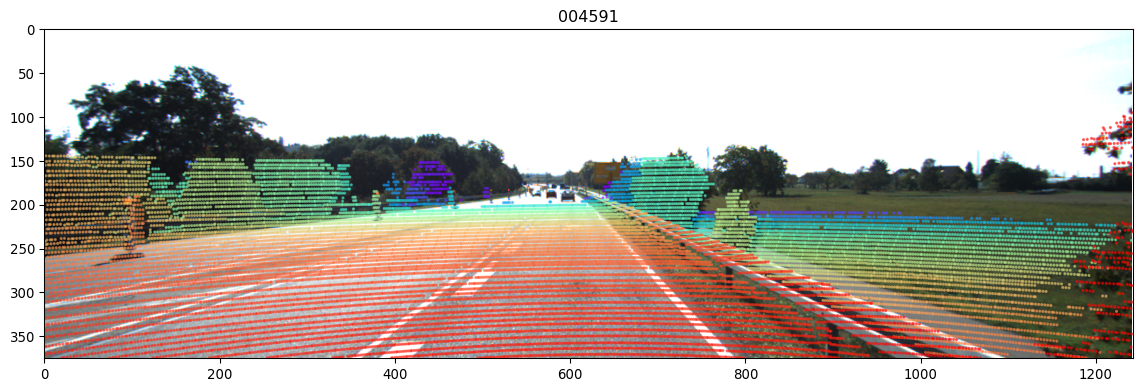

In [9]:
# Caso en el que la regresión no funcionaría correctamente
show_point_cloud_projected(4591)

# 2D bounding boxes

In [10]:
def get_bounding_boxes_2D(image_id):
    df_frame = df[df['frame'] == image_id]
    bbs = []
    for index, row in df_frame.iterrows():
        bb = (row['left'], row['top'], row['right'], row['bottom'])
        bbs.append(bb)
    return bbs

In [11]:
def show_bounding_boxes_2D(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    
    # do projection staff
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # restrict canvas in range
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    # draw bounding boxes
    bbs = get_bounding_boxes_2D(image_id)
    for bb in bbs:
        plt.gca().add_patch(Rectangle((bb[0], bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='purple',facecolor='none'))
    
    # plt.savefig(KITTI_DATASET+'projection/{name}.png',bbox_inches='tight')
    plt.show()

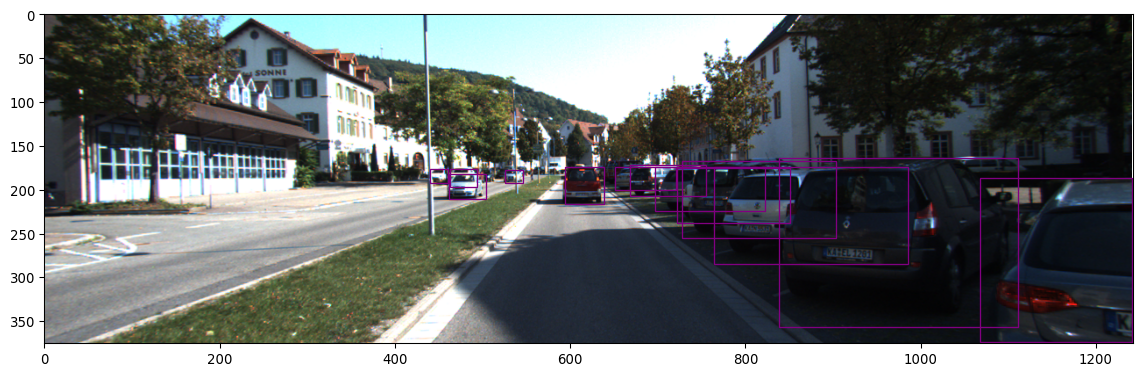

In [12]:
show_bounding_boxes_2D(500)

# 1st distance approximation approach

In [13]:
def get_gt_distance(image_id):
    df_frame = df_train[df_train['frame'] == image_id]
    distances = []
    for index, row in df_frame.iterrows():
        distances.append(row['distance'])
    return distances

In [14]:
def get_distance_pc_projection(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    bbs_distance = [[],[]]
    for bb in bbs:
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            bbs_distance[0].append(bb)
            bbs_distance[1].append(distance)
    
    return bbs_distance

In [15]:
get_distance_pc_projection(1000)

[[(798.93, 169.95, 1060.55, 250.42),
  (561.02, 184.64, 587.94, 208.4),
  (468.53, 187.25, 501.75, 210.97)],
 [14.171984473285315, 47.58936221146112, 45.1118412020316]]

In [16]:
def show_image_distance(image_id, bbs_distance):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    
    # show image
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    # draw bounding boxes
    gt_distances = get_gt_distance(image_id)
    if(len(bbs_distance[0]) > 0):
        bbs = bbs_distance[0]
        distances = bbs_distance[1]
        for bb, distance, gt_distance in zip(bbs, distances, gt_distances):
            plt.gca().add_patch(Rectangle((bb[0], bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='purple',facecolor='none'))
            plt.text(bb[0],bb[1],str(round(distance,2))+"m",color='green')
            plt.text(bb[0],bb[1]+10,str(round(gt_distance,2))+"m",color='red')
            print(distance)
            print(gt_distance)
            print("---")
        
    plt.show()

14.171984473285315
15.90967944365945
---
47.58936221146112
49.6786282016724
---
45.1118412020316
48.01710320292136
---


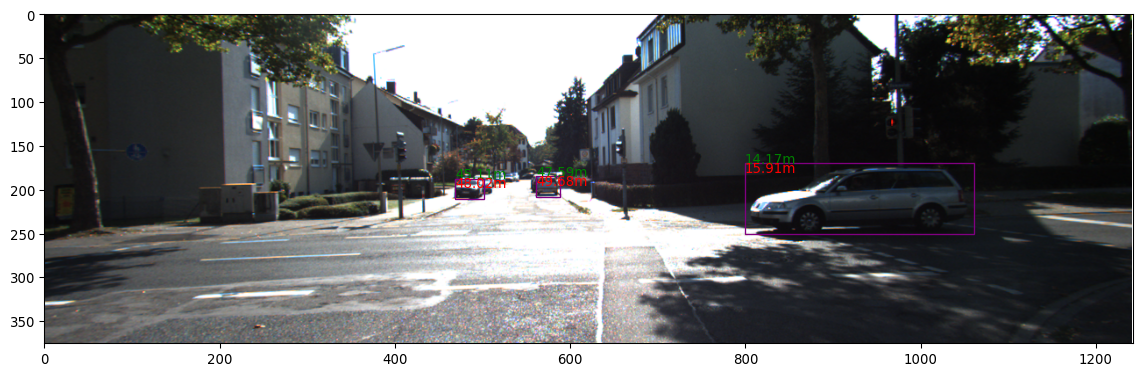

In [17]:
image_id = 1000
show_image_distance(image_id, get_distance_pc_projection(image_id))

### MSE of the distance with the 1st method by occlusion

In [18]:
def evaluate_mse_distances(bbs_distance_gt, bbs_distance_pred):
    y_true = []
    y_pred = []
    
    if(len(bbs_distance_pred[0]) == 0): # Checks if doesn't have any predictions
        return None
    else:
        for bb_gt, distance_gt in zip(bbs_distance_gt[0], bbs_distance_gt[1]): 
            for bb_pred, distance_pred in zip(bbs_distance_pred[0], bbs_distance_pred[1]):  
                if(bb_gt == bb_pred):
                    y_true.append(distance_gt)
                    y_pred.append(distance_pred)
                    break
        return mean_squared_error(y_true, y_pred)

In [19]:
# Create loading bar
n_frames = 0
for occlusion in range(4):
    n_frames += len(df_val[df_val['occluded'] <= occlusion]['frame'].unique())
loading_bar = tqdm(total=n_frames, position=0, leave=True)

def mse(frame):
    df_frame = df_val[df_val['frame'] == frame]
    bbs_distance_gt = [get_bounding_boxes_2D(frame),df_frame['distance']]
    mse_value = evaluate_mse_distances(bbs_distance_gt, get_distance_pc_projection(frame))
    
    # Update loading bar
    loading_bar.update(1)
    
    return mse_value

occlusions = [0, 1, 2, 3]
text_occlusions = ["with level 0 of occlusion", "with level 1 of occlusion or less", "with level 2 of occlusion or less", "with level 3 of occlusion or less"]

for occlusion, text_occlusion in zip(occlusions, text_occlusions):
    df_occlusion = df_val[df_val['occluded'] <= occlusion]
    mse_by_frame = df_occlusion['frame'].unique()
    start_time = time.time()
    mse_by_frame = list(map(mse, mse_by_frame))
    print("--- %s seconds to calculate MSE %s ---" % (time.time() - start_time, text_occlusion))

    start_time = time.time()
    mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))
    print("--- %s seconds to eliminate None %s ---" % (time.time() - start_time, text_occlusion))

    start_time = time.time()
    mean_mse = statistics.mean(mse_by_frame_without_none)
    print("--- %s seconds calculate the mean of all frames %s ---" % (time.time() - start_time, text_occlusion))

    print("\nMean of all MSE by frame %s = %s\n" % (text_occlusion, mean_mse))

 24%|██▍       | 1422/5903 [00:29<01:28, 50.78it/s]

--- 29.750051975250244 seconds to calculate MSE with level 0 of occlusion ---
--- 9.632110595703125e-05 seconds to eliminate None with level 0 of occlusion ---
--- 0.0012691020965576172 seconds calculate the mean of all frames with level 0 of occlusion ---

Mean of all MSE by frame with level 0 of occlusion = 31.524133758240385



 49%|████▉     | 2913/5903 [01:03<01:28, 33.69it/s]

--- 33.28603219985962 seconds to calculate MSE with level 1 of occlusion or less ---
--- 0.00017571449279785156 seconds to eliminate None with level 1 of occlusion or less ---
--- 0.0013613700866699219 seconds calculate the mean of all frames with level 1 of occlusion or less ---

Mean of all MSE by frame with level 1 of occlusion or less = 31.26200831850464



 75%|███████▍  | 4410/5903 [01:35<00:33, 44.77it/s]

--- 32.00111699104309 seconds to calculate MSE with level 2 of occlusion or less ---
--- 0.0001666545867919922 seconds to eliminate None with level 2 of occlusion or less ---
--- 0.0013492107391357422 seconds calculate the mean of all frames with level 2 of occlusion or less ---

Mean of all MSE by frame with level 2 of occlusion or less = 31.26200831850464



100%|█████████▉| 5901/5903 [02:08<00:00, 40.13it/s]

--- 33.249799728393555 seconds to calculate MSE with level 3 of occlusion or less ---
--- 0.0001773834228515625 seconds to eliminate None with level 3 of occlusion or less ---
--- 0.0013382434844970703 seconds calculate the mean of all frames with level 3 of occlusion or less ---

Mean of all MSE by frame with level 3 of occlusion or less = 31.26200831850464



# 2nd distance approximation approach

In [20]:
def get_intersection_between_rectangles(bb1, bb2):
    """
    bb: [left, top, right, bottom]
    """
    left = max(bb1[0], bb2[0])
    top = max(bb1[1], bb2[1])
    right = min(bb1[2], bb2[2])
    bottom = min(bb1[3], bb2[3])
    if left > right:
        return None
    if top > bottom:
        return None
    return [left, top, right, bottom]

In [21]:
def get_point_cloud_projected_without_intersections(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    n_bbs = len(bbs)
    for i in range(n_bbs):
        for j in range(i+1, n_bbs):
            intersection = get_intersection_between_rectangles(bbs[i], bbs[j])
            if (intersection != None):
                filter_intersection = (intersection[0] < projected_pc[0,:]) &\
                                      (intersection[1] < projected_pc[1,:]) &\
                                      (projected_pc[0,:] < intersection[2]) &\
                                      (projected_pc[1,:] < intersection[3])
                
                projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                               projected_pc[1,:][~filter_intersection],\
                                               projected_pc[2,:][~filter_intersection]), axis=0)
                
                
    return projected_pc

In [22]:
def show_point_cloud_projected_without_intersections(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    
    # do projection staff
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # restrict canvas in range
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    cam = get_point_cloud_projected_without_intersections(image_id)
    # generate color map from depth
    u,v,z = cam
    plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=2)
    plt.title(name)
    
    # draw bounding boxes
    bbs = get_bounding_boxes_2D(image_id)
    for bb in bbs:
        plt.gca().add_patch(Rectangle((bb[0], bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='purple',facecolor='none'))
    
    plt.show()

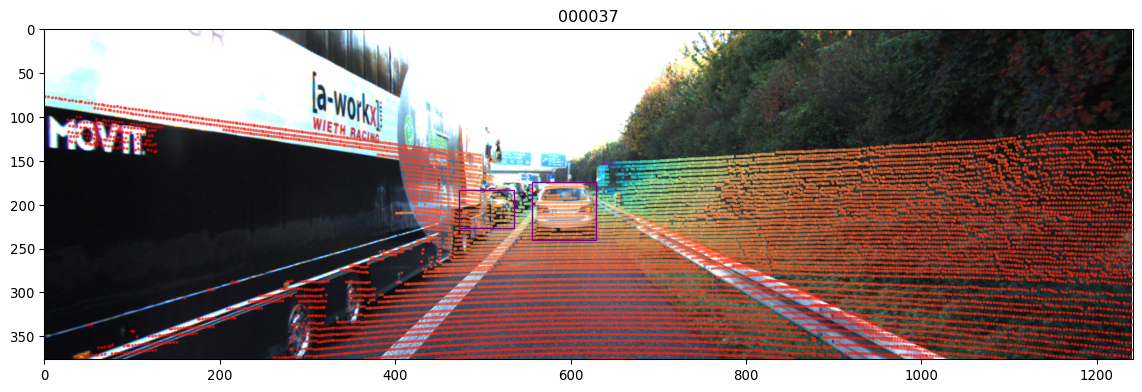

In [23]:
# Difficult situation (37)
show_point_cloud_projected_without_intersections(37)

In [24]:
def get_point_cloud_projected_without_intersections(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    n_bbs = len(bbs)
    for i in range(n_bbs):
        for j in range(i+1, n_bbs):
            intersection = get_intersection_between_rectangles(bbs[i], bbs[j])
            if (intersection != None):
                filter_intersection = (intersection[0] < projected_pc[0,:]) &\
                                      (intersection[1] < projected_pc[1,:]) &\
                                      (projected_pc[0,:] < intersection[2]) &\
                                      (projected_pc[1,:] < intersection[3])
                
                projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                               projected_pc[1,:][~filter_intersection],\
                                               projected_pc[2,:][~filter_intersection]), axis=0)
                
                
    return projected_pc

In [25]:
# Function to execute the regression by height model
def approximate_distance_height(type_name, top, bottom, bb_complete, model):
    height = bottom - top
    if type_name == 'Car':
        if bb_complete:
            f = model.car.bb_complete.function
            return f(height, *model.car.bb_complete.variables)
        else:
            f = model.car.bb_incomplete.function
            return f(height, *model.car.bb_incomplete.variables)
    elif type_name == 'Pedestrian':
        f = model.pedestrian.function
        return f(height, *model.pedestrian.variables)
    elif type_name == 'Cyclist':
        f = model.cyclist.function
        return f(height, *model.cyclist.variables)
    else:
        raise ValueError("Type must be Car, Pedestrian or Cyclist")

In [26]:
# Object to open the pkl file
def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c

class Regression_model:
    def __init__(self, function, variables):
        self.function = function
        self.variables = variables
    def __str__(self):
        return "function = %s, variables = %s"%(self.function, self.variables)

class Regression_model_class:
    def __init__(self, model_car, model_pedestrian, model_cyclist):
        self.car = model_car
        self.pedestrian = model_pedestrian
        self.cyclist = model_cyclist
    def __str__(self):
        return "car: {%s} \npedestrian: {%s} \ncyclist: {%s}\n"%(self.car, self.pedestrian, self.cyclist)
        
class Regression_model_bb:
    def __init__(self, bb_complete, bb_incomplete):
        self.bb_complete = bb_complete
        self.bb_incomplete = bb_incomplete
    def __str__(self):
        return "bb_complete: {%s},\nbb_incomplete: {%s}\n"%(self.bb_complete, self.bb_incomplete)

In [27]:
# Approximate distance by removing the points of the previous vehicles
def get_distance_pc_projection_without_intersections(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    types = df[df['frame'] == image_id]['type'].tolist()
    incomplete = df[df['frame'] == image_id]['incomplete_2d_horizontal'].tolist()
    
    bbs_distance = [[],[]]
    # Sort bbs by height (change to sort by regression method using height)
    with open('height_model.pkl', 'rb') as f:
        height_model = pickle.load(f)
        id_bbs = sorted(list(range(len(bbs))),
                     key=lambda i: approximate_distance_height(types[i], bbs[i][1], bbs[i][3],
                                                               not incomplete[i], height_model))
        bbs = list(enumerate(bbs))
        bbs.sort(key=lambda x: id_bbs.index(x[0]))
        bbs = list(map(lambda x: x[1], bbs))
        
    # Iterate over bb
    for bb in bbs:
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            bbs_distance[0].append(bb)
            bbs_distance[1].append(distance)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_distance

In [28]:
get_distance_pc_projection_without_intersections(1)

[[(676.6, 163.95, 688.98, 193.93), (387.63, 181.54, 423.81, 203.12)],
 [45.75585182809419, 56.809068486478445]]

In [29]:
df_train

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian       0.00       0.0  -0.20  712.40  143.00   
1          1   0         Car       0.00       0.0   1.85  387.63  181.54   
2          1   1     Cyclist       0.00       3.0  -1.65  676.60  163.95   
3          2   0         Car       0.00       0.0  -1.67  657.39  190.13   
4          3   0         Car       0.00       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
27993   5983   8         Car       0.00       2.0  -1.72  668.22  167.79   
27994   5983   9         Car       0.00       1.0  -1.66  640.25  174.03   
27995   5983  10         Car       0.77       3.0   2.27    0.00  196.98   
27996   5983  11         Car       0.00       2.0  -1.57  594.88  172.76   
27997   5983  12         Car       0.71       3.0   2.25    0.00  183.60   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
27993  726.04  215.88    1.56   1.48    3.36   2.95  1.42  25.30 -1.61   
27994  671.68  198.24    1.38   1.55    3.60   2.70  1.47  43.39 -1.60   
27995   95.57  298.45    1.35   1.59    3.41  -9.21  1.73  10.06  1.55   
27996  633.46  207.96    1.52   1.67    3.61   0.16  1.54  33.23 -1.56   
27997   58.86  241.34    1.32   1.43    3.25 -14.83  1.59  16.84  1.54   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
27993  25.510956         48.09        57.82       0.11   
27994  43.498770         24.21        31.43       0.06   
27995  13.748476        101.47        95.57      -0.72   
27996  33.266050         35.20        38.58       0.01   
27997  22.495391         57.74        58.86      -0.71   

       incomplete_2d_horizontal  incomplete_2d_bottom  
0                         False                 False  
1                         False                 False  
2                         False                 False  
3                         False                 False  
4                         False                 False  
...                         ...                   ...  
27993                     False                 False  
27994                     False                 False  
27995                      True                 False  
27996                     False                 False  
27997                      True                 False  

[27998 rows x 23 columns]

In [30]:
frame_list, left_list, top_list, right_list, bottom_list, distance_approx_list = [], [], [], [], [], []
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
# Iterate over frames
for frame in df['frame'].unique():
    # Get distance approimation using 2nd method
    bbs2D, distance_approx = get_distance_pc_projection_without_intersections(frame)
    # Fill columns data in lists
    frame_list.extend(len(distance_approx)*[frame])
    ## Iterate over bbs2D
    for bb2D in bbs2D:
        left_list.append(bb2D[0])
        top_list.append(bb2D[1])
        right_list.append(bb2D[2])
        bottom_list.append(bb2D[3])
    distance_approx_list.extend(distance_approx)
    
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = ['frame','left','top','right','bottom','distance_approx_2'],
                         data = list(zip(frame_list, left_list, top_list, right_list, bottom_list, distance_approx_list)))

100%|█████████▉| 7480/7481 [02:37<00:00, 48.55it/s]

In [31]:
df_approx

frame    left     top   right  bottom  distance_approx_2
0          0  712.40  143.00  810.73  307.92          12.379818
1          1  676.60  163.95  688.98  193.93          45.755852
2          1  387.63  181.54  423.81  203.12          56.809068
3          2  657.39  190.13  700.07  223.39          33.731449
4          3  614.24  181.78  727.31  284.77          12.274350
...      ...     ...     ...     ...     ...                ...
34007   7480  501.01  178.40  523.53  228.03          24.206338
34008   7480  344.07  180.05  479.10  224.15          25.222057
34009   7480  382.70  179.71  495.48  219.10          29.558852
34010   7480  631.71  179.85  678.40  214.37          30.272493
34011   7480  619.92  176.90  647.01  199.92          46.099539

[34012 rows x 6 columns]

In [32]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom'],
                  right_on=['frame','left','top','right','bottom'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom'],
                  right_on=['frame','left','top','right','bottom'])

In [33]:
df_train

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian       0.00       0.0  -0.20  712.40  143.00   
1          1   0         Car       0.00       0.0   1.85  387.63  181.54   
2          1   1     Cyclist       0.00       3.0  -1.65  676.60  163.95   
3          2   0         Car       0.00       0.0  -1.67  657.39  190.13   
4          3   0         Car       0.00       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
27306   5983   7         Car       0.00       2.0  -1.71  678.38  179.02   
27307   5983   8         Car       0.00       2.0  -1.72  668.22  167.79   
27308   5983   9         Car       0.00       1.0  -1.66  640.25  174.03   
27309   5983  10         Car       0.77       3.0   2.27    0.00  196.98   
27310   5983  12         Car       0.71       3.0   2.25    0.00  183.60   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
27306  765.40  234.72    1.32   1.70    4.04   2.84  1.50  19.37 -1.57   
27307  726.04  215.88    1.56   1.48    3.36   2.95  1.42  25.30 -1.61   
27308  671.68  198.24    1.38   1.55    3.60   2.70  1.47  43.39 -1.60   
27309   95.57  298.45    1.35   1.59    3.41  -9.21  1.73  10.06  1.55   
27310   58.86  241.34    1.32   1.43    3.25 -14.83  1.59  16.84  1.54   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
27306  19.634472         55.70        87.02       0.14   
27307  25.510956         48.09        57.82       0.11   
27308  43.498770         24.21        31.43       0.06   
27309  13.748476        101.47        95.57      -0.72   
27310  22.495391         57.74        58.86      -0.71   

       incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx_2  
0                         False                 False          12.379818  
1                         False                 False          56.809068  
2                         False                 False          45.755852  
3                         False                 False          33.731449  
4                         False                 False          12.274350  
...                         ...                   ...                ...  
27306                     False                 False          20.092260  
27307                     False                 False          40.078162  
27308                     False                 False          41.639171  
27309                      True                 False           7.581888  
27310                      True                 False           7.577095  

[27311 rows x 24 columns]

In [34]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6696   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6697   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6698   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6699   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6700   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6696  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6697  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6698  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6699  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6700  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6696  19.776334         72.60       167.73       0.29   
6697  27.044846         44.10       135.03      -0.26   
6698  29.623654         39.39       112.78      -0.23   
6699  32.083610         34.52        46.69       0.06   
6700  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx_2  
0                        False                 False          33.951394  
1                        False                 False          46.418030  
2                        False                 False          49.005706  
3                        False                 False          50.347864  
4                        False                 False          51.782106  
...                        ...                   ...                ...  
6696                     False                 False          19.033945  
6697                     False                 False          25.222057  
6698                     False                 False          29.558852  
6699                     False                 False          30.272493  
6700                     False                 False          46.099539  

[6701 rows x 24 columns]

### MSE of the distance with the 2nd method by occlusion

In [35]:
df_train['distance_error'] = df_train['distance'] - df_train['distance_approx_2']
df_val['distance_error'] = df_val['distance'] - df_val['distance_approx_2']

In [36]:
df_train

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian       0.00       0.0  -0.20  712.40  143.00   
1          1   0         Car       0.00       0.0   1.85  387.63  181.54   
2          1   1     Cyclist       0.00       3.0  -1.65  676.60  163.95   
3          2   0         Car       0.00       0.0  -1.67  657.39  190.13   
4          3   0         Car       0.00       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
27306   5983   7         Car       0.00       2.0  -1.71  678.38  179.02   
27307   5983   8         Car       0.00       2.0  -1.72  668.22  167.79   
27308   5983   9         Car       0.00       1.0  -1.66  640.25  174.03   
27309   5983  10         Car       0.77       3.0   2.27    0.00  196.98   
27310   5983  12         Car       0.71       3.0   2.25    0.00  183.60   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
27306  765.40  234.72    1.32   1.70    4.04   2.84  1.50  19.37 -1.57   
27307  726.04  215.88    1.56   1.48    3.36   2.95  1.42  25.30 -1.61   
27308  671.68  198.24    1.38   1.55    3.60   2.70  1.47  43.39 -1.60   
27309   95.57  298.45    1.35   1.59    3.41  -9.21  1.73  10.06  1.55   
27310   58.86  241.34    1.32   1.43    3.25 -14.83  1.59  16.84  1.54   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
27306  19.634472         55.70        87.02       0.14   
27307  25.510956         48.09        57.82       0.11   
27308  43.498770         24.21        31.43       0.06   
27309  13.748476        101.47        95.57      -0.72   
27310  22.495391         57.74        58.86      -0.71   

       incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx_2  \
0                         False                 False          12.379818   
1                         False                 False          56.809068   
2                         False                 False          45.755852   
3                         False                 False          33.731449   
4                         False                 False          12.274350   
...                         ...                   ...                ...   
27306                     False                 False          20.092260   
27307                     False                 False          40.078162   
27308                     False                 False          41.639171   
27309                      True                 False           7.581888   
27310                      True                 False           7.577095   

       distance_error  
0           -3.646285  
1            4.018829  
2            0.332282  
3            0.869848  
4            1.098417  
...               ...  
27306       -0.457788  
27307      -14.567205  
27308        1.859599  
27309        6.166589  
27310       14.918295  

[27311 rows x 25 columns]

In [37]:
# Create loading bar
n_frames = 0
for occlusion in range(4):
    n_frames += len(df_val[df_val['occluded'] <= occlusion]['frame'].unique())
loading_bar = tqdm(total=n_frames, position=0, leave=True)

def mse(frame):
    df_frame = df_val[df_val['frame'] == frame]
    bbs_distance_gt = df_frame['distance'].tolist()
    bbs_distance_approx = df_frame['distance_approx_2'].tolist()
    mse_value = mean_squared_error(bbs_distance_gt, bbs_distance_approx)
    
    # Update loading bar
    loading_bar.update(1)
    
    return mse_value

occlusions = [0, 1, 2, 3]
text_occlusions = ["with level 0 of occlusion", "with level 1 of occlusion or less", "with level 2 of occlusion or less", "with level 3 of occlusion or less"]

for occlusion, text_occlusion in zip(occlusions, text_occlusions):
    df_occlusion = df_val[df_val['occluded'] <= occlusion]
    mse_by_frame = df_occlusion['frame'].unique()
    start_time = time.time()
    mse_by_frame = list(map(mse, mse_by_frame))
    print("--- %s seconds to calculate MSE %s ---" % (time.time() - start_time, text_occlusion))

    mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))
    print("--- %s seconds to eliminate None %s ---" % (time.time() - start_time, text_occlusion))

    start_time = time.time()
    mean_mse = statistics.mean(mse_by_frame_without_none)
    print("--- %s seconds calculate the mean of all frames %s ---" % (time.time() - start_time, text_occlusion))

    print("\nMean of all MSE by frame %s = %s\n" % (text_occlusion, mean_mse))

 29%|██▊       | 1690/5900 [00:01<00:02, 1597.44it/s]

--- 0.8514113426208496 seconds to calculate MSE with level 0 of occlusion ---
--- 0.8516542911529541 seconds to eliminate None with level 0 of occlusion ---
--- 0.0013759136199951172 seconds calculate the mean of all frames with level 0 of occlusion ---

Mean of all MSE by frame with level 0 of occlusion = 26.138245930776307



 54%|█████▍    | 3182/5900 [00:01<00:01, 1672.39it/s]

--- 0.9150230884552002 seconds to calculate MSE with level 1 of occlusion or less ---
--- 0.9152815341949463 seconds to eliminate None with level 1 of occlusion or less ---
--- 0.0013773441314697266 seconds calculate the mean of all frames with level 1 of occlusion or less ---

Mean of all MSE by frame with level 1 of occlusion or less = 26.170172482158797



 77%|███████▋  | 4570/5900 [00:02<00:00, 1696.33it/s]

--- 0.8673772811889648 seconds to calculate MSE with level 2 of occlusion or less ---
--- 0.86757493019104 seconds to eliminate None with level 2 of occlusion or less ---
--- 0.0013663768768310547 seconds calculate the mean of all frames with level 2 of occlusion or less ---

Mean of all MSE by frame with level 2 of occlusion or less = 26.170172482158797



 98%|█████████▊| 5771/5900 [00:03<00:00, 1718.22it/s]

--- 0.8783795833587646 seconds to calculate MSE with level 3 of occlusion or less ---
--- 0.8786115646362305 seconds to eliminate None with level 3 of occlusion or less ---
--- 0.0015082359313964844 seconds calculate the mean of all frames with level 3 of occlusion or less ---

Mean of all MSE by frame with level 3 of occlusion or less = 26.1526907575021



### MSE of the distance with the 2nd method by KITTI difficulties

In [38]:
def define_difficulty(row):
    height = row['bottom'] - row['top']
    occlusion = row['occluded']
    truncation = row['truncated']
    if(height >= 40 and occlusion == 0 and truncation <= 0.15):
        return 0
    elif(height >= 25 and occlusion <= 1 and truncation <= 0.3):
        return 1
    elif(height >= 25 and occlusion <= 2 and truncation <= 0.5):
        return 2
    else:
        return 3

In [39]:
df_train['difficulty'] = df_train.apply(lambda row: define_difficulty(row), axis=1)
df_val['difficulty'] = df_val.apply(lambda row: define_difficulty(row), axis=1)

In [40]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6696   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6697   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6698   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6699   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6700   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6696  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6697  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6698  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6699  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6700  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6696  19.776334         72.60       167.73       0.29   
6697  27.044846         44.10       135.03      -0.26   
6698  29.623654         39.39       112.78      -0.23   
6699  32.083610         34.52        46.69       0.06   
6700  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx_2  \
0                        False                 False          33.951394   
1                        False                 False          46.418030   
2                        False                 False          49.005706   
3                        False                 False          50.347864   
4                        False                 False          51.782106   
...                        ...                   ...                ...   
6696                     False                 False          19.033945   
6697                     False                 False          25.222057   
6698                     False                 False          29.558852   
6699                     False                 False          30.272493   
6700                     False                 False          46.099539   

      distance_error  difficulty  
0           1.282255           1  
1           0.850756           1  
2           1.840128           1  
3           2.364212           1  
4           1.801950           3  
...              ...         ...  
6696        0.742389           2  
6697        1.822789           1  
6698        0.064803           2  
6699        1.811117           1  
6700        0.974503           3  

[6701 rows x 26 columns]

In [41]:
# Create loading bar
n_frames = 0
for difficulty in range(3):
    n_frames += len(df_val[df_val['difficulty'] <= difficulty]['frame'].unique())
loading_bar = tqdm(total=n_frames, position=0, leave=True)

def mse(frame):
    df_frame = df_val[df_val['frame'] == frame]
    bbs_distance_gt = df_frame['distance'].tolist()
    bbs_distance_approx = df_frame['distance_approx_2'].tolist()
    mse_value = mean_squared_error(bbs_distance_gt, bbs_distance_approx)
    
    # Update loading bar
    loading_bar.update(1)
    
    return mse_value

difficulties = [0, 1, 2]
text_difficulties = ["Easy", "Moderate", "Hard"]

for difficulty, text_difficulty in zip(difficulties, text_difficulties):
    df_difficulty = df_val[df_val['difficulty'] <= difficulty]
    mse_by_frame = df_difficulty['frame'].unique()
    start_time = time.time()
    mse_by_frame = list(map(mse, mse_by_frame))
    print("--- %s seconds to calculate MSE %s ---" % (time.time() - start_time, text_difficulty))

    start_time = time.time()
    mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))
    print("--- %s seconds to eliminate None %s ---" % (time.time() - start_time, text_difficulty))

    start_time = time.time()
    mean_mse = statistics.mean(mse_by_frame_without_none)
    print("--- %s seconds calculate the mean of all frames %s ---" % (time.time() - start_time, text_difficulty))

    print("\nMean of all MSE by frame %s = %s\n" % (text_difficulty, mean_mse))

 35%|███▌      | 1361/3844 [00:00<00:01, 1676.96it/s]

--- 0.6177513599395752 seconds to calculate MSE Easy ---
--- 0.0001766681671142578 seconds to eliminate None Easy ---
--- 0.0010001659393310547 seconds calculate the mean of all frames Easy ---

Mean of all MSE by frame Easy = 24.64755241059143



 71%|███████   | 2719/3844 [00:01<00:00, 1677.61it/s]

--- 0.8257195949554443 seconds to calculate MSE Moderate ---
--- 0.000179290771484375 seconds to eliminate None Moderate ---
--- 0.00135040283203125 seconds calculate the mean of all frames Moderate ---

Mean of all MSE by frame Moderate = 26.170884336247116



 98%|█████████▊| 3770/3844 [00:02<00:00, 1755.40it/s]

--- 0.8094770908355713 seconds to calculate MSE Hard ---
--- 0.00017881393432617188 seconds to eliminate None Hard ---
--- 0.0013506412506103516 seconds calculate the mean of all frames Hard ---

Mean of all MSE by frame Hard = 26.473229869113958



### MSE of the distance with the 2nd method by KITTI difficulties and classes

In [42]:
difficulties = [0, 1, 2]                       
classes = ["Car","Cyclist","Pedestrian"]
text_difficulties = ["Easy", "Moderate", "Hard"]

# Create loading bar
n_frames = 0
for difficulty in range(3):
    for class_name in classes:
        n_frames += len(df_val[(df_val['difficulty'] <= difficulty) & \
                                  (df_val['type'] == class_name)]['frame'].unique())
loading_bar = tqdm(total=n_frames, position=0, leave=True)

def mse(frame):
    df_frame = df_val[df_val['frame'] == frame]
    bbs_distance_gt = df_frame['distance'].tolist()
    bbs_distance_approx = df_frame['distance_approx_2'].tolist()
    mse_value = mean_squared_error(bbs_distance_gt, bbs_distance_approx)
    
    # Update loading bar
    loading_bar.update(1)
    
    return mse_value

# Iterate over difficulties
for difficulty, text_difficulty in zip(difficulties, text_difficulties):
    # Iterate over classes
    for class_name in classes:                  
        df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
        mse_by_frame = df_difficulty['frame'].unique()
        start_time = time.time()
        mse_by_frame = list(map(mse, mse_by_frame))

        mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))

        mean_mse = statistics.mean(mse_by_frame_without_none)
        print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

        print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mean_mse))

 22%|██▏       | 1021/4575 [00:00<00:02, 1684.14it/s]

--- 0.500272274017334 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 28.00804599577812

--- 0.05762648582458496 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 17.460818593876557

--- 0.138810396194458 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 13.87878197134478



 60%|█████▉    | 2728/4575 [00:01<00:01, 1694.28it/s]

--- 0.7218441963195801 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 28.790771346490104

--- 0.0852503776550293 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 23.81339862935039



 67%|██████▋   | 3078/4575 [00:01<00:00, 1720.68it/s]

--- 0.17310261726379395 seconds to calculate MSE, Moderate difficulty, Pedestrian class  ---

Mean of all MSE by frame, Moderate difficulty, Pedestrian class = 16.16043622123402



 94%|█████████▍| 4303/4575 [00:02<00:00, 1729.65it/s]

--- 0.7078819274902344 seconds to calculate MSE, Hard difficulty, Car class  ---

Mean of all MSE by frame, Hard difficulty, Car class = 29.04626487133532

--- 0.08852815628051758 seconds to calculate MSE, Hard difficulty, Cyclist class  ---

Mean of all MSE by frame, Hard difficulty, Cyclist class = 24.07942414646917



 98%|█████████▊| 4476/4575 [00:02<00:00, 1695.77it/s]

--- 0.19823861122131348 seconds to calculate MSE, Hard difficulty, Pedestrian class  ---

Mean of all MSE by frame, Hard difficulty, Pedestrian class = 16.351033148294935



# Closest distance to distance to the center

In [43]:
MDistanceE = df_train.apply(lambda row: row['distance']-row['distance_approx_2'], axis=1).quantile(q=[0.25,0.5,0.75])
print("Mean distance error for all classes:")
print(MDistanceE, end="\n\n")

for distance in [20, 40, 60]:
    MDistanceE_distance = df_train[(distance-20 < df_train['distance_approx_2']) & (df_train['distance_approx_2'] < distance)].apply(lambda row: row['distance']-row['distance_approx_2'], axis=1).quantile(q=[0.25,0.5,0.75])
    print("Mean distance error for all classes and %s < distance %s:" % (distance-20, distance))
    print(MDistanceE_distance, end="\n\n")
    
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_class = df_train[df_train['type'] == class_name].apply(lambda row: row['distance']-row['distance_approx_2'], axis=1).quantile(q=[0.25,0.5,0.75])
    print("Mean distance error for %s class:" % (class_name))
    print(MDistanceE_class, end="\n\n")

Mean distance error for all classes:
0.25    0.372371
0.50    1.492974
0.75    2.214249
dtype: float64

Mean distance error for all classes and 0 < distance 20:
0.25    0.171044
0.50    1.254267
0.75    1.999504
dtype: float64

Mean distance error for all classes and 20 < distance 40:
0.25    0.559781
0.50    1.549945
0.75    2.285395
dtype: float64

Mean distance error for all classes and 40 < distance 60:
0.25    0.927442
0.50    1.781148
0.75    2.930305
dtype: float64

Mean distance error for Car class:
0.25    0.952778
0.50    1.637865
0.75    2.426870
dtype: float64

Mean distance error for Cyclist class:
0.25   -3.021275
0.50   -0.303513
0.75    0.354047
dtype: float64

Mean distance error for Pedestrian class:
0.25   -1.294302
0.50    0.116298
0.75    0.821391
dtype: float64



In [44]:
print(max(df_train['distance_approx_2']))
print(min(df_train['distance_approx_2']))

79.54851495763957
3.314993071731425


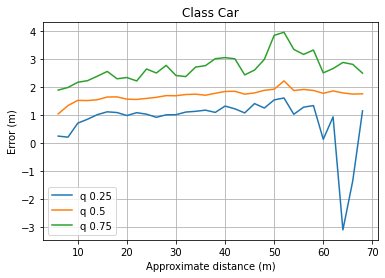

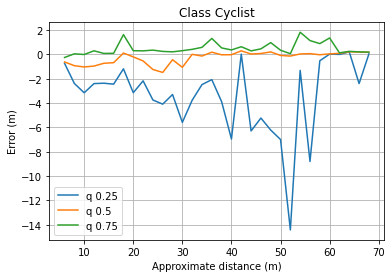

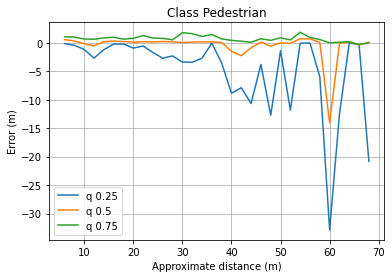

In [45]:
jump = 2
start = 5
end = 68
# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train[(distance < df_train['distance_approx_2']) & \
                                        (df_train['distance_approx_2'] < distance+jump) & \
                                        (df_train['type'] == class_name)].apply(lambda row: row['distance']-row['distance_approx_2'], axis=1).quantile(q=[0.25,0.5,0.75])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_25 = list(map(lambda x: x.get(0.25), MDistanceE_distances))
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    q_0_75 = list(map(lambda x: x.get(0.75), MDistanceE_distances))

    # Create plot
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_25)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_75)
    plt.legend(['q 0.25', 'q 0.5', 'q 0.75'])
    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')
    plt.grid()
    plt.show()

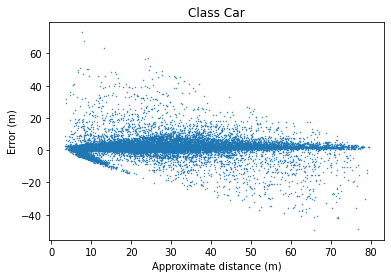

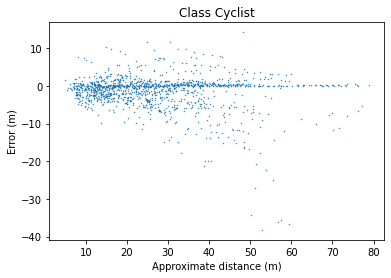

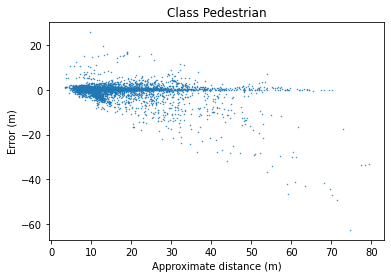

In [46]:
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_car = df_train[df_train['type'] == class_name]

    Y = df_train_car['distance_error'].values
    X = df_train_car['distance_approx_2'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.2)
    plt.show()

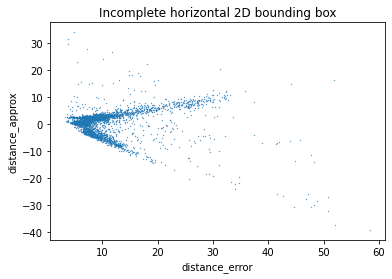

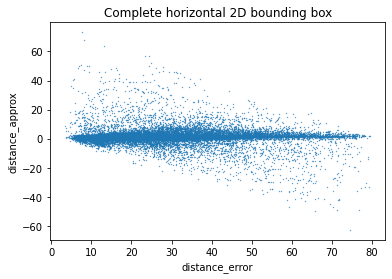

In [47]:
df_incomplete_2d_horizontal = df_train[df_train['incomplete_2d_horizontal'] == True]
df_complete_2d_horizontal = df_train[df_train['incomplete_2d_horizontal'] == False]

Y = df_incomplete_2d_horizontal['distance_error'].values
X = df_incomplete_2d_horizontal['distance_approx_2'].values
plt.title('Incomplete horizontal 2D bounding box')
plt.xlabel('distance_error')
plt.ylabel('distance_approx')
plt.scatter(X, Y, s=0.1)
plt.show()

Y = df_complete_2d_horizontal['distance_error'].values
X = df_complete_2d_horizontal['distance_approx_2'].values
plt.scatter(X, Y, s=0.1)
plt.title('Complete horizontal 2D bounding box')
plt.xlabel('distance_error')
plt.ylabel('distance_approx')
plt.show()

### Worst case

In [48]:
display(df_train[df_train['distance']-df_train['distance_approx_2'] > 60])

frame  id type  truncated  occluded  alpha    left     top   right  \
11339   2527   8  Car        0.0       0.0   1.78  599.29  173.88  621.72   
16668   3695   7  Car        0.0       1.0   1.80  603.71  172.54  626.59   
24387   5352   8  Car        0.0       1.0   1.75  599.19  177.40  621.62   

       bottom  height  width  length     x     y      z    ry   distance  \
11339  189.63    1.60   1.60    3.77  0.07  1.73  75.73  1.78  75.749790   
16668  186.65    1.52   1.65    4.10  0.60  1.52  80.80  1.81  80.816523   
24387  193.09    1.61   1.70    3.97  0.07  2.11  76.69  1.75  76.719053   

       height_image  width_image  theta_ray  incomplete_2d_horizontal  \
11339         15.75        22.43       0.00                     False   
16668         14.11        22.88       0.01                     False   
24387         15.69        22.43       0.00                     False   

       incomplete_2d_bottom  distance_approx_2  distance_error  difficulty  
11339                 False           8.210726       67.539064           3  
16668                 False           7.682149       73.134374           3  
24387                 False          13.194057       63.524996           3

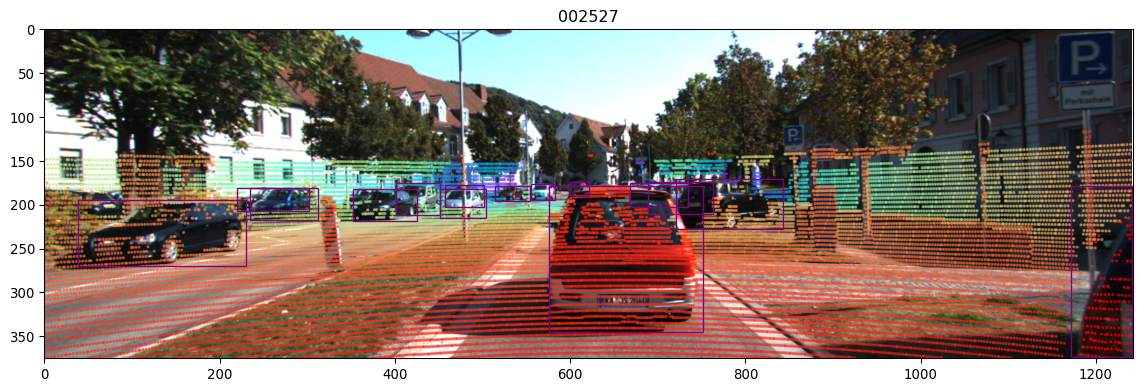

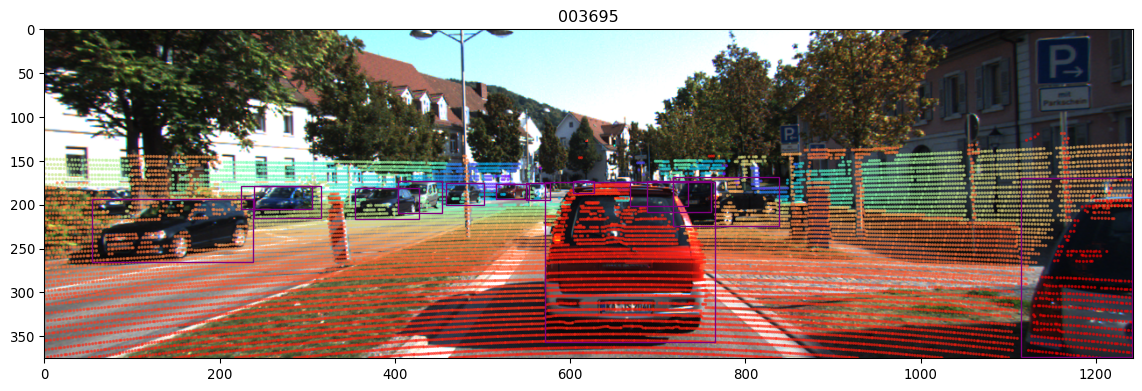

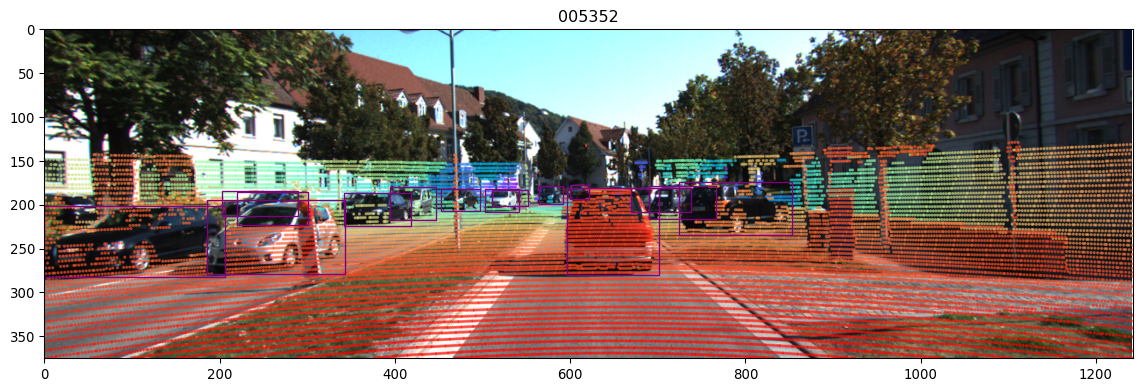

In [49]:
show_point_cloud_projected_without_intersections(2527)
show_point_cloud_projected_without_intersections(3695)
show_point_cloud_projected_without_intersections(5352)

In [50]:
df_train

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian       0.00       0.0  -0.20  712.40  143.00   
1          1   0         Car       0.00       0.0   1.85  387.63  181.54   
2          1   1     Cyclist       0.00       3.0  -1.65  676.60  163.95   
3          2   0         Car       0.00       0.0  -1.67  657.39  190.13   
4          3   0         Car       0.00       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
27306   5983   7         Car       0.00       2.0  -1.71  678.38  179.02   
27307   5983   8         Car       0.00       2.0  -1.72  668.22  167.79   
27308   5983   9         Car       0.00       1.0  -1.66  640.25  174.03   
27309   5983  10         Car       0.77       3.0   2.27    0.00  196.98   
27310   5983  12         Car       0.71       3.0   2.25    0.00  183.60   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
27306  765.40  234.72    1.32   1.70    4.04   2.84  1.50  19.37 -1.57   
27307  726.04  215.88    1.56   1.48    3.36   2.95  1.42  25.30 -1.61   
27308  671.68  198.24    1.38   1.55    3.60   2.70  1.47  43.39 -1.60   
27309   95.57  298.45    1.35   1.59    3.41  -9.21  1.73  10.06  1.55   
27310   58.86  241.34    1.32   1.43    3.25 -14.83  1.59  16.84  1.54   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
27306  19.634472         55.70        87.02       0.14   
27307  25.510956         48.09        57.82       0.11   
27308  43.498770         24.21        31.43       0.06   
27309  13.748476        101.47        95.57      -0.72   
27310  22.495391         57.74        58.86      -0.71   

       incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx_2  \
0                         False                 False          12.379818   
1                         False                 False          56.809068   
2                         False                 False          45.755852   
3                         False                 False          33.731449   
4                         False                 False          12.274350   
...                         ...                   ...                ...   
27306                     False                 False          20.092260   
27307                     False                 False          40.078162   
27308                     False                 False          41.639171   
27309                      True                 False           7.581888   
27310                      True                 False           7.577095   

       distance_error  difficulty  
0           -3.646285           0  
1            4.018829           3  
2            0.332282           3  
3            0.869848           1  
4            1.098417           0  
...               ...         ...  
27306       -0.457788           2  
27307      -14.567205           2  
27308        1.859599           3  
27309        6.166589           3  
27310       14.918295           3  

[27311 rows x 26 columns]

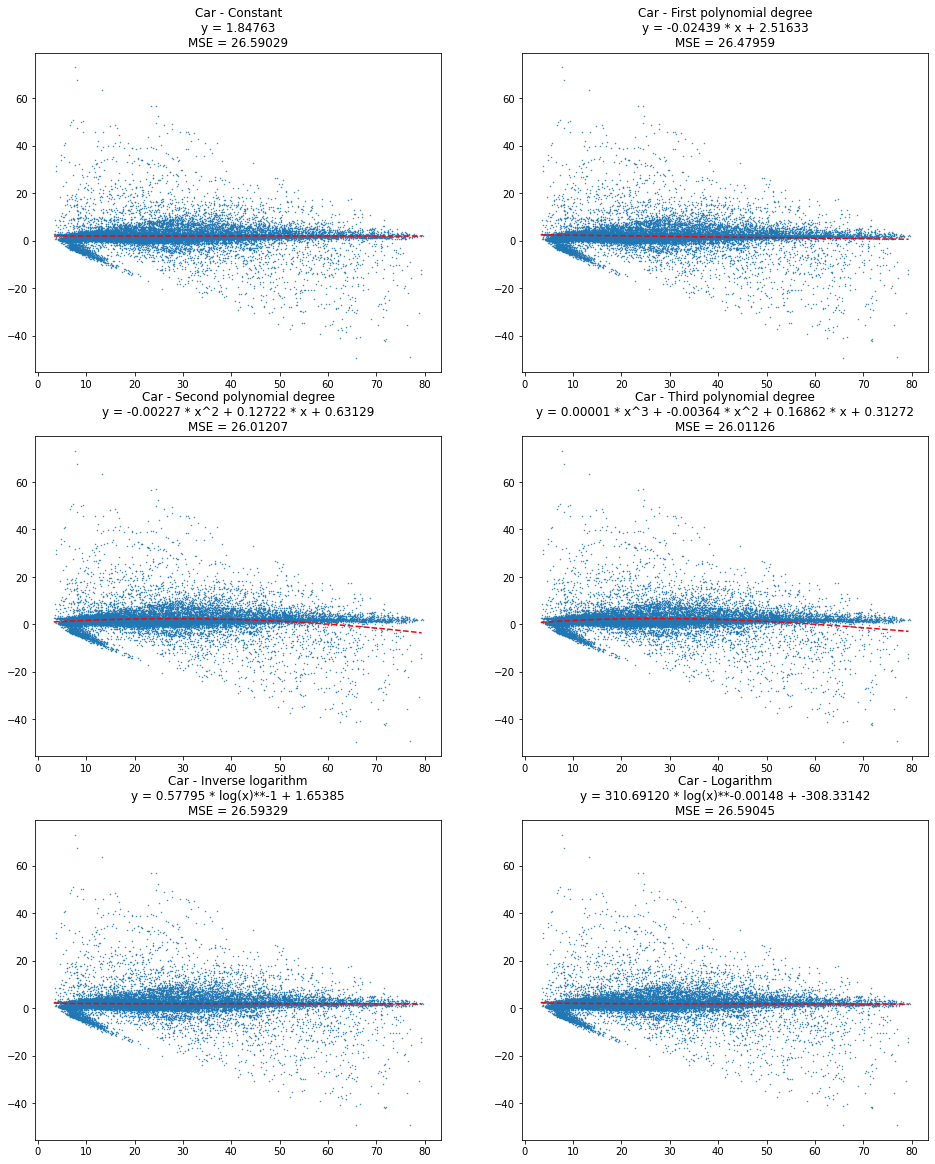

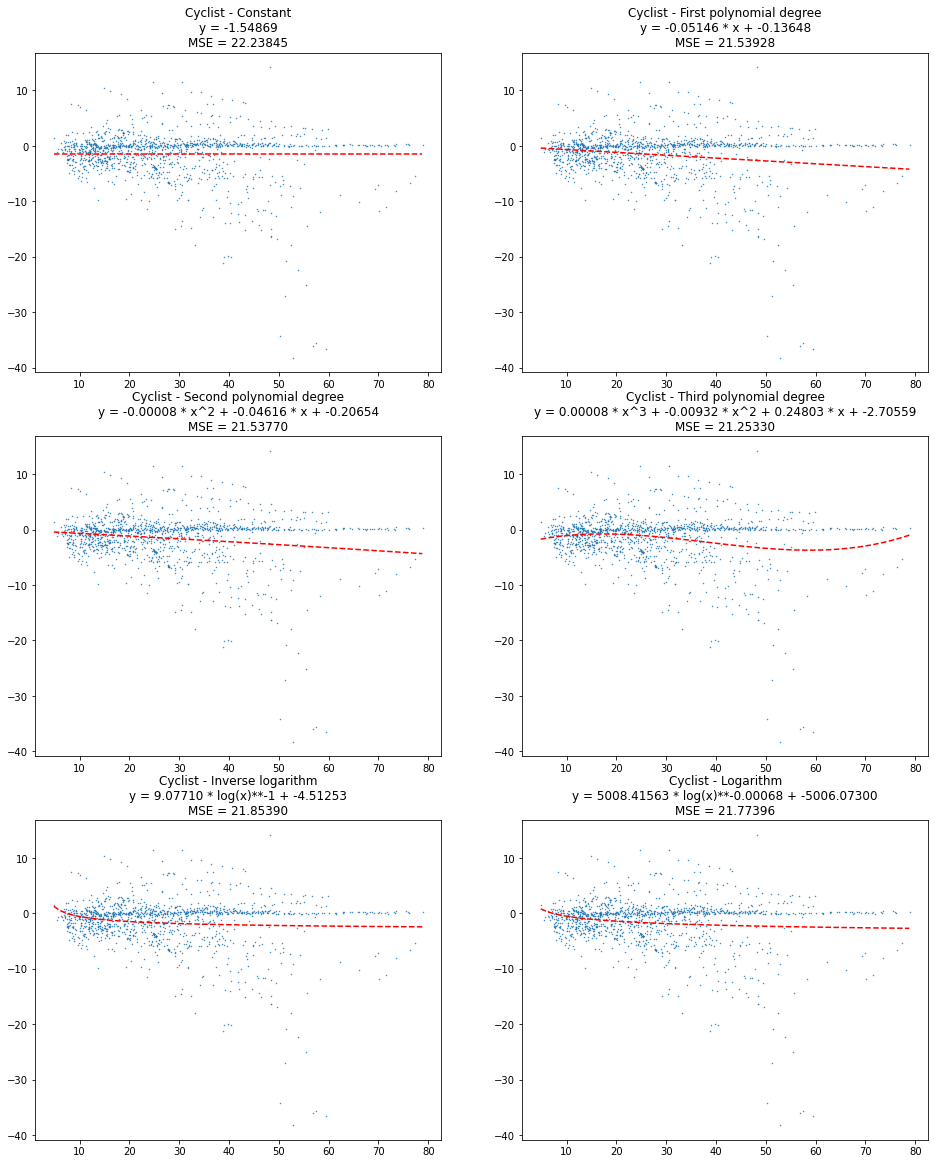

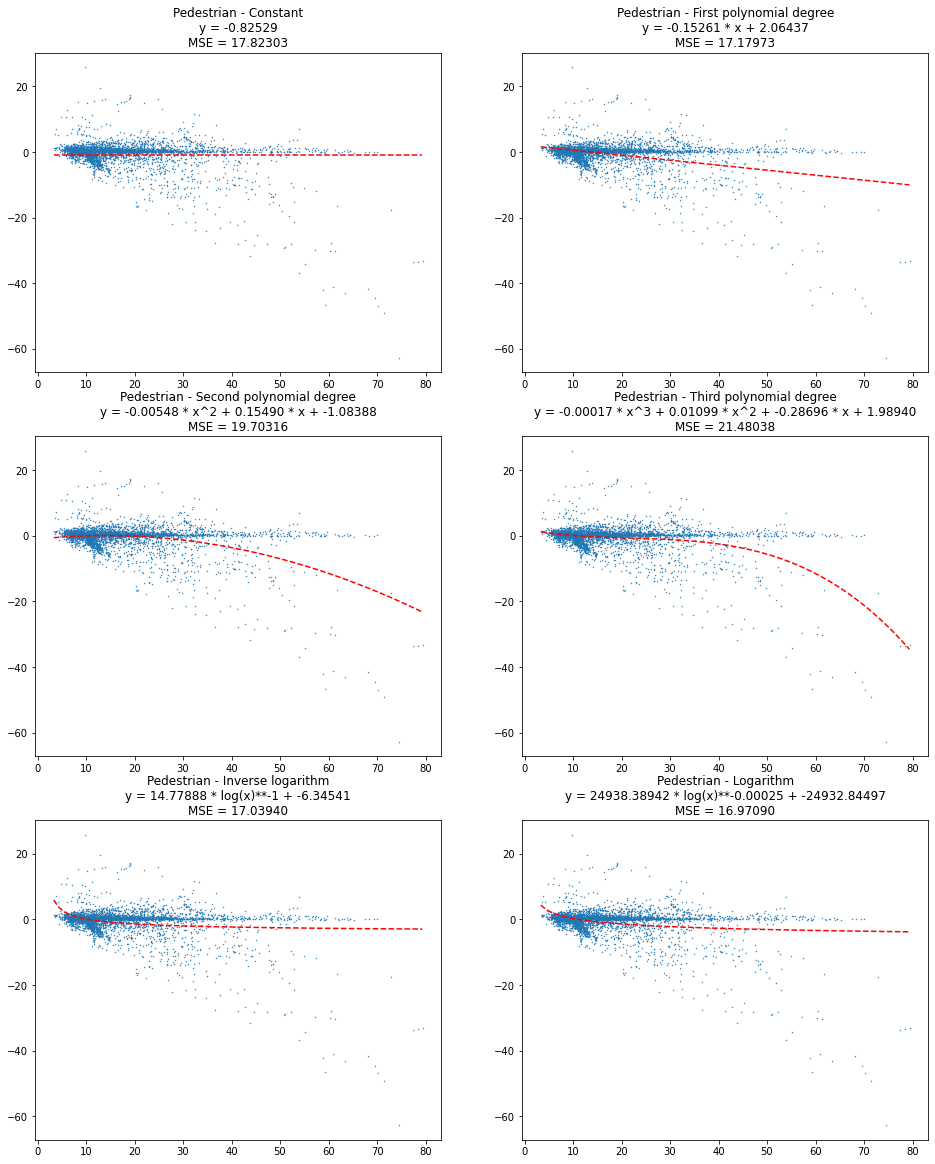

In [51]:
def objective_const(x, a):
    return a

def objective_f(x, a, b):
    return a * x + b

def objective_2f(x, a, b, c):
    return a * x**2 + b * x + c

def objective_3f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def objective_log_1f(x, a, b):
    return a * np.log(x)**-1 + b 

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c
    
functions = [objective_const, objective_f, objective_2f, objective_3f, objective_log_1f, objective_log_f]
titles = ['%s - Constant\ny = %.5f\nMSE = %.5f',
          '%s - First polynomial degree\ny = %.5f * x + %.5f\nMSE = %.5f',
          '%s - Second polynomial degree\ny = %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
          '%s - Third polynomial degree\ny = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
          '%s - Inverse logarithm\ny = %.5f * log(x)**-1 + %.5f\nMSE = %.5f',
          '%s - Logarithm\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f']

jump = 2
start = 5
end = 68
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train[(distance < df_train['distance_approx_2']) & \
                                        (df_train['distance_approx_2'] < distance+jump) & \
                                        (df_train['type'] == class_name)].apply(lambda row: row['distance']-row['distance_approx_2'], axis=1).quantile(q=[0.25,0.5,0.75])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    
    plt.figure(figsize=(16, 20))
    
    for i in range(len(functions)):

        df_train_class = df_train[df_train['type'] == class_name]
        df_val_class = df_val[df_val['type'] == class_name]

        Y_to_show = q_0_5
        X_to_show = np.array(list(range(start,end,jump)))+jump/2

        Y = df_train_class['distance_error']
        X = df_train_class['distance_approx_2']

        Y_to_predict = df_val_class['distance_error'].values
        X_to_predict = df_val_class['distance_approx_2'].values
        
        function = functions[i]
        plt.subplot(3, 2, i+1)
        popt, _ = curve_fit(function, X, Y, maxfev = 10000)
        plt.scatter(X, Y, s=0.2)
        X_line = np.arange(min(X), max(X), 1)
        Y_line = list(map(lambda x: functions[i](x, *popt), X_line))
        #Y_line = function(X_line, *popt)
        plt.plot(X_line, Y_line, '--', color='red')
        Y_pred = function(X_to_predict, *popt)
        if type(Y_pred) != np.ndarray:
            Y_pred = [Y_pred]*len(Y_to_predict)
        mse = mean_squared_error(Y_to_predict, Y_pred)
        plt.title(titles[i] % (class_name, *popt, mse))
    plt.show()

Car - Second polynomial degree\
Cyclist - First polynomial degree\
Pedestrian - First polynomial degree

In [52]:
popt_car = None
popt_cyclist = None
popt_pedestrian = None

for class_name in ["Car","Cyclist","Pedestrian"]:

    df_train_class = df_train[df_train['type'] == class_name]
    
    Y = df_train_class['distance_error']
    X = df_train_class['distance_approx_2']
    
    popt, _ = curve_fit(objective_f, X, Y, maxfev = 1000)
    if class_name == "Cyclist":
        popt_cyclist = popt
    elif class_name == "Pedestrian":
        popt_pedestrian = popt
        
    popt, _ = curve_fit(objective_2f, X, Y, maxfev = 1000)
    if class_name == "Car":
        popt_car = popt

In [53]:
class Regression_model:
    def __init__(self, function, variables):
        self.function = function
        self.variables = variables
    def __str__(self):
        return "function = %s, variables = %s"%(self.function, self.variables)

class Regression_model_class:
    def __init__(self, model_car, model_pedestrian, model_cyclist):
        self.car = model_car
        self.pedestrian = model_pedestrian
        self.cyclist = model_cyclist
    def __str__(self):
        return "car: {%s} \npedestrian: {%s} \ncyclist: {%s}\n"%(self.car, self.pedestrian, self.cyclist)
        
class Regression_model_bb:
    def __init__(self, bb_complete, bb_incomplete):
        self.bb_complete = bb_complete
        self.bb_incomplete = bb_incomplete
    def __str__(self):
        return "bb_complete: {%s},\nbb_incomplete: {%s}\n"%(self.bb_complete, self.bb_incomplete)

In [54]:
pc_proj_refinement_model = Regression_model_class(Regression_model(objective_2f, popt_car),
                                                  Regression_model(objective_f, popt_pedestrian),
                                                  Regression_model(objective_f, popt_cyclist))
print(pc_proj_refinement_model)

car: {function = <function objective_2f at 0x7fa1ec138c80>, variables = [-0.00227258  0.12721679  0.63129216]} 
pedestrian: {function = <function objective_f at 0x7fa1ec138d08>, variables = [-0.15261171  2.06437251]} 
cyclist: {function = <function objective_f at 0x7fa1ec138d08>, variables = [-0.05146148 -0.13647697]}



In [55]:
#with open('pc_proj_refinement_model.pkl', 'wb') as f:
#    f.write(pickle.dumps(pc_proj_refinement_model))

## MSE of the distance with the 2nd method by KITTI difficulties and classes applying distance rectification

In [56]:
def get_types(image_id):
    df_frame = df[df['frame'] == image_id]
    types = list(df_frame['type'])
    return types

In [57]:
def approximate_distance(image_id, model):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    types = get_types(image_id)
    incomplete = df[df['frame'] == image_id]['incomplete_2d_horizontal'].tolist()
   
    # Sort bbs by height (change to sort by regression method using height)
    with open('height_model.pkl', 'rb') as f:
        height_model = pickle.load(f)
        id_bbs = sorted(list(range(len(bbs))),
                     key=lambda i: approximate_distance_height(types[i], bbs[i][1], bbs[i][3],
                                                               not incomplete[i], height_model))
        bbs = list(enumerate(bbs))
        types = list(enumerate(types))
        bbs.sort(key=lambda x: id_bbs.index(x[0]))
        types.sort(key=lambda x: id_bbs.index(x[0]))
        bbs = list(map(lambda x: x[1], bbs))
        types = list(map(lambda x: x[1], types))
        
    # Create output dict
    bbs_distance = {'frame':[image_id]*len(types),
                    'left':list(map(lambda x: x[0], bbs)),
                    'top':list(map(lambda x: x[1], bbs)),
                    'right':list(map(lambda x: x[2], bbs)),
                    'bottom':list(map(lambda x: x[3], bbs)),
                    'type':types,
                    'distance':[]}
    
    # Iterate over bb
    for type_name, bb in zip(types, bbs):
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            # Approximate distance
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            height = bb[3] - bb[1] # bottom - top
            if type_name == 'Car':
                f = model.car.function
                rectification = f(distance, *model.car.variables)
                distance += rectification
            elif type_name == 'Pedestrian':
                f = model.pedestrian.function
                rectification = f(distance, *model.pedestrian.variables)
                distance += rectification
            elif type_name == 'Cyclist':
                f = model.cyclist.function
                rectification = f(distance, *model.cyclist.variables)
                distance += rectification
            else:
                print("Type must be Car, Pedestrian or Cyclist")
            
            bbs_distance['distance'].append(distance)
        else:
            bbs_distance['distance'].append(-1)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_distance

In [58]:
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
distance_approx = {'frame':[], 'left':[], 'top':[], 'right':[], 'bottom':[], 'type':[], 'distance':[]}
for frame in df['frame'].unique():
    frame_approx = approximate_distance(frame, pc_proj_refinement_model)
    dict_items = ['frame','left','top','right','bottom','type','distance']
    for item in dict_items:
        distance_approx[item].extend(frame_approx[item])
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = dict_items[:-1]+['distance_approx_2_rect_1'],
                         data = list(zip(distance_approx['frame'], distance_approx['left'],
                                         distance_approx['top'], distance_approx['right'],
                                         distance_approx['bottom'], distance_approx['type'],
                                         distance_approx['distance'])))

100%|█████████▉| 7479/7481 [02:41<00:00, 45.16it/s]

In [59]:
df_approx[df_approx['distance_approx_2_rect_1'] == -1]

frame    left     top   right  bottom type  distance_approx_2_rect_1
11         6  548.00  171.33  572.40  194.42  Car                      -1.0
152       47  296.94  182.19  393.12  231.61  Car                      -1.0
231       67  478.81  182.19  515.67  207.52  Car                      -1.0
280       79  483.32  182.25  518.76  207.09  Car                      -1.0
346       95  648.79  178.98  673.89  194.56  Car                      -1.0
...      ...     ...     ...     ...     ...  ...                       ...
34722   7454  494.58  174.55  562.32  230.70  Car                      -1.0
34736   7458   53.53  171.56  313.85  278.25  Car                      -1.0
34824   7475    0.00  211.77   81.10  279.33  Car                      -1.0
34837   7479  562.01  188.13  699.25  275.91  Car                      -1.0
34839   7479  654.41  185.96  752.38  245.05  Car                      -1.0

[844 rows x 7 columns]

In [60]:
df_approx

frame    left     top   right  bottom        type  \
0          0  712.40  143.00  810.73  307.92  Pedestrian   
1          1  676.60  163.95  688.98  193.93     Cyclist   
2          1  387.63  181.54  423.81  203.12         Car   
3          2  657.39  190.13  700.07  223.39         Car   
4          3  614.24  181.78  727.31  284.77         Car   
...      ...     ...     ...     ...     ...         ...   
34851   7480  501.01  178.40  523.53  228.03     Cyclist   
34852   7480  344.07  180.05  479.10  224.15         Car   
34853   7480  382.70  179.71  495.48  219.10         Car   
34854   7480  631.71  179.85  678.40  214.37         Car   
34855   7480  619.92  176.90  647.01  199.92         Car   

       distance_approx_2_rect_1  
0                     12.554885  
1                     43.264711  
2                     57.333191  
3                     36.068179  
4                     14.124759  
...                         ...  
34851                 22.824167  
34852                 27.616310  
34853                 31.964913  
34854                 32.672306  
34855                 47.765849  

[34856 rows x 7 columns]

In [61]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])

In [62]:
df_train

frame  id        type  truncated  occluded  alpha    left     top  \
0          0   0  Pedestrian       0.00       0.0  -0.20  712.40  143.00   
1          1   0         Car       0.00       0.0   1.85  387.63  181.54   
2          1   1     Cyclist       0.00       3.0  -1.65  676.60  163.95   
3          2   0         Car       0.00       0.0  -1.67  657.39  190.13   
4          3   0         Car       0.00       0.0   1.55  614.24  181.78   
...      ...  ..         ...        ...       ...    ...     ...     ...   
27306   5983   7         Car       0.00       2.0  -1.71  678.38  179.02   
27307   5983   8         Car       0.00       2.0  -1.72  668.22  167.79   
27308   5983   9         Car       0.00       1.0  -1.66  640.25  174.03   
27309   5983  10         Car       0.77       3.0   2.27    0.00  196.98   
27310   5983  12         Car       0.71       3.0   2.25    0.00  183.60   

        right  bottom  height  width  length      x     y      z    ry  \
0      810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41  0.01   
1      423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49  1.57   
2      688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84 -1.55   
3      700.07  223.39    1.41   1.58    4.36   3.18  2.27  34.38 -1.58   
4      727.31  284.77    1.57   1.73    4.15   1.00  1.75  13.22  1.62   
...       ...     ...     ...    ...     ...    ...   ...    ...   ...   
27306  765.40  234.72    1.32   1.70    4.04   2.84  1.50  19.37 -1.57   
27307  726.04  215.88    1.56   1.48    3.36   2.95  1.42  25.30 -1.61   
27308  671.68  198.24    1.38   1.55    3.60   2.70  1.47  43.39 -1.60   
27309   95.57  298.45    1.35   1.59    3.41  -9.21  1.73  10.06  1.55   
27310   58.86  241.34    1.32   1.43    3.25 -14.83  1.59  16.84  1.54   

        distance  height_image  width_image  theta_ray  \
0       8.733533        164.92        98.33       0.21   
1      60.827897         21.58        36.18      -0.28   
2      46.088134         29.98        12.38       0.10   
3      34.601296         33.26        42.68       0.09   
4      13.372767        102.99       113.07       0.07   
...          ...           ...          ...        ...   
27306  19.634472         55.70        87.02       0.14   
27307  25.510956         48.09        57.82       0.11   
27308  43.498770         24.21        31.43       0.06   
27309  13.748476        101.47        95.57      -0.72   
27310  22.495391         57.74        58.86      -0.71   

       incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx_2  \
0                         False                 False          12.379818   
1                         False                 False          56.809068   
2                         False                 False          45.755852   
3                         False                 False          33.731449   
4                         False                 False          12.274350   
...                         ...                   ...                ...   
27306                     False                 False          20.092260   
27307                     False                 False          40.078162   
27308                     False                 False          41.639171   
27309                      True                 False           7.581888   
27310                      True                 False           7.577095   

       distance_error  difficulty  distance_approx_2_rect_1  
0           -3.646285           0                 12.554885  
1            4.018829           3                 57.333191  
2            0.332282           3                 43.264711  
3            0.869848           1                 36.068179  
4            1.098417           0                 14.124759  
...               ...         ...                       ...  
27306       -0.457788           2                 22.362186  
27307      -14.567205           2                 42.157714  
27308        1.859599           3    

In [63]:
difficulties = [0, 1, 2]                       
classes = ["Car","Cyclist","Pedestrian"]
text_difficulties = ["Easy", "Moderate", "Hard"]

# Create loading bar
n_frames = 0
for difficulty in range(3):
    for class_name in classes:
        n_frames += len(df_val[(df_val['difficulty'] <= difficulty) & \
                                  (df_val['type'] == class_name)]['frame'].unique())
loading_bar = tqdm(total=n_frames, position=0, leave=True)

def mse(frame):
    df_frame = df_val[df_val['frame'] == frame]
    bbs_distance_gt = df_frame['distance'].tolist()
    bbs_distance_approx = df_frame['distance_approx_2_rect_1'].tolist()
    mse_value = mean_squared_error(bbs_distance_gt, bbs_distance_approx)
    
    # Update loading bar
    loading_bar.update(1)
    
    return mse_value

# Iterate over difficulties
for difficulty, text_difficulty in zip(difficulties, text_difficulties):
    # Iterate over classes
    for class_name in classes:                  
        df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
        mse_by_frame = df_difficulty['frame'].unique()
        start_time = time.time()
        mse_by_frame = list(map(mse, mse_by_frame))

        mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))

        mean_mse = statistics.mean(mse_by_frame_without_none)
        print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

        print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mean_mse))

 23%|██▎       | 1037/4575 [00:00<00:02, 1718.25it/s]

--- 0.4913473129272461 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 24.32361381763951

--- 0.05811023712158203 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 13.643892482571903

--- 0.13393020629882812 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 12.608019356058954



 57%|█████▋    | 2591/4575 [00:01<00:01, 1675.67it/s]

--- 0.7183034420013428 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 24.22471081540436

--- 0.0876152515411377 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 19.890338480514473



 68%|██████▊   | 3102/4575 [00:01<00:00, 1688.65it/s]

--- 0.17676997184753418 seconds to calculate MSE, Moderate difficulty, Pedestrian class  ---

Mean of all MSE by frame, Moderate difficulty, Pedestrian class = 14.264999556969423



 94%|█████████▍| 4311/4575 [00:02<00:00, 1703.79it/s]

--- 0.7182638645172119 seconds to calculate MSE, Hard difficulty, Car class  ---

Mean of all MSE by frame, Hard difficulty, Car class = 24.41408863057843

--- 0.08963561058044434 seconds to calculate MSE, Hard difficulty, Cyclist class  ---

Mean of all MSE by frame, Hard difficulty, Cyclist class = 20.02071112767123



 98%|█████████▊| 4484/4575 [00:02<00:00, 1710.27it/s]

--- 0.19356489181518555 seconds to calculate MSE, Hard difficulty, Pedestrian class  ---

Mean of all MSE by frame, Hard difficulty, Pedestrian class = 14.555630432964307



# Closest distance to distance to the center after removing outliers

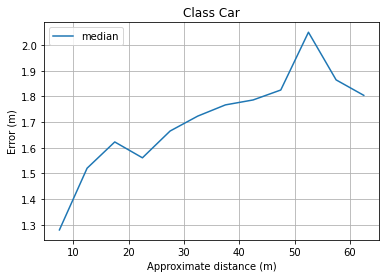

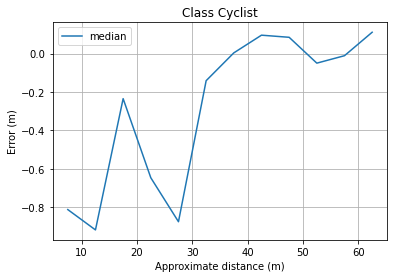

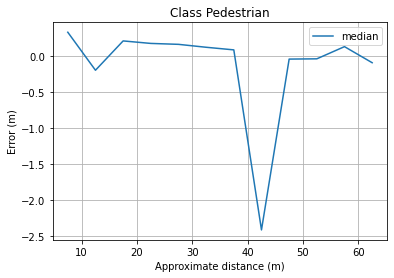

In [64]:
jump = 5
start = 5
end = 65
# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train[(distance < df_train['distance_approx_2']) & \
                                        (df_train['distance_approx_2'] < distance+jump) & \
                                        (df_train['type'] == class_name)].apply(lambda row: row['distance']-row['distance_approx_2'], axis=1).quantile(q=[0.25,0.5,0.75])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))

    # Create plot
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_5)
    plt.legend(['median'])
    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')
    plt.grid()
    plt.show()

In [65]:
# Calculate regression curve of Car and Cyclist to rectify the approximation
jump = 5
start = 5
end = 65
dict_class_median = {'Car':[], 'Cyclist':[], 'Pedestrian':[]}
# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train[(distance < df_train['distance_approx_2']) & \
                                        (df_train['distance_approx_2'] < distance+jump) & \
                                        (df_train['type'] == class_name)].apply(lambda row: row['distance']-row['distance_approx_2'], axis=1).quantile(q=[0.25,0.5,0.75])
        MDistanceE_distances.append(MDistanceE_distance)
    median = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    dict_class_median[class_name] = median

In [66]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6696   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6697   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6698   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6699   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6700   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6696  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6697  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6698  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6699  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6700  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6696  19.776334         72.60       167.73       0.29   
6697  27.044846         44.10       135.03      -0.26   
6698  29.623654         39.39       112.78      -0.23   
6699  32.083610         34.52        46.69       0.06   
6700  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx_2  \
0                        False                 False          33.951394   
1                        False                 False          46.418030   
2                        False                 False          49.005706   
3                        False                 False          50.347864   
4                        False                 False          51.782106   
...                        ...                   ...                ...   
6696                     False                 False          19.033945   
6697                     False                 False          25.222057   
6698                     False                 False          29.558852   
6699                     False                 False          30.272493   
6700                     False                 False          46.099539   

      distance_error  difficulty  distance_approx_2_rect_1  
0           1.282255           1                 36.282274  
1           0.850756           1                 41.398467  
2           1.840128           1                 50.413607  
3           2.364212           1                 51.623465  
4           1.801950           3                 52.907280  
...              ...         ...                       ...  
6696        0.742389           2                 21.263338  
6697        1.822789           1                 27.616310  
6698        0.064803           2                 31.964913  
6699        1.811117           1

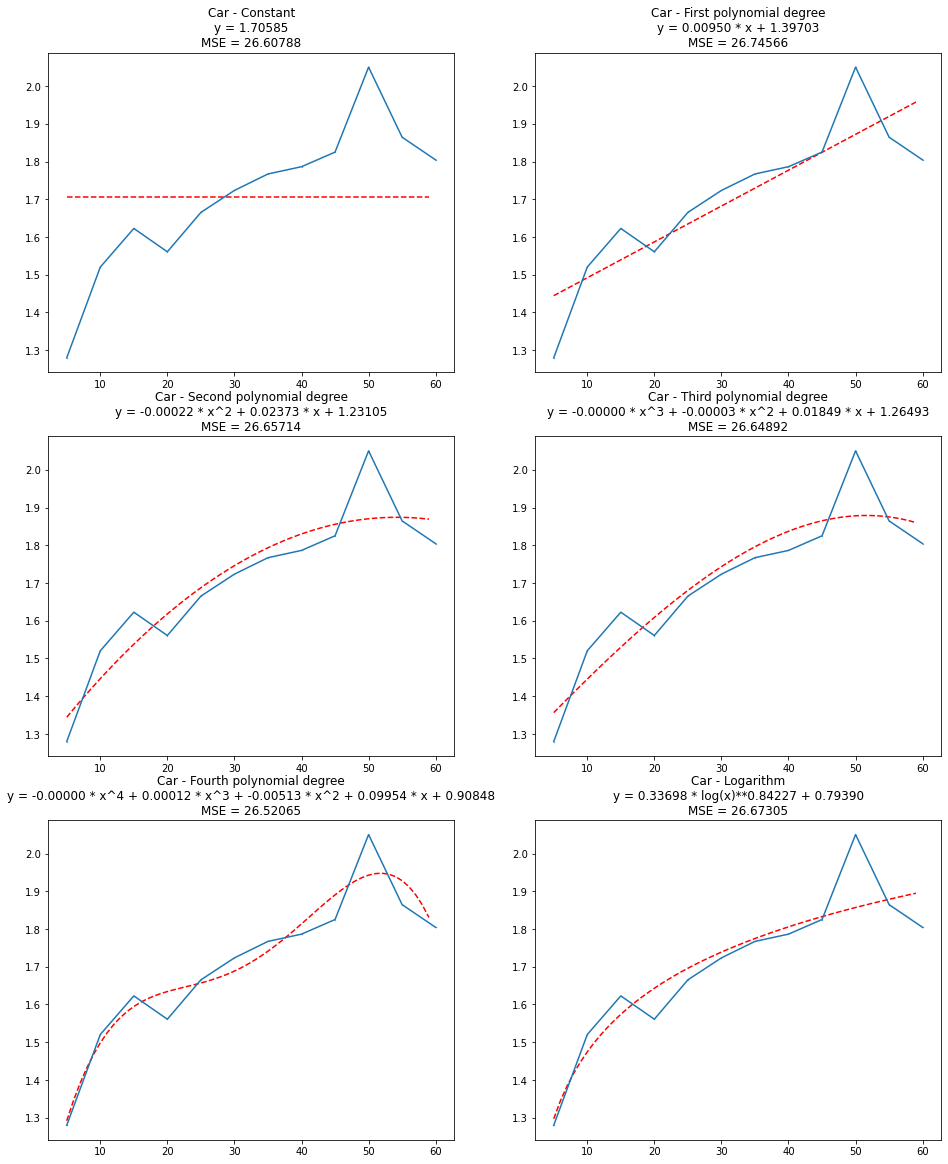

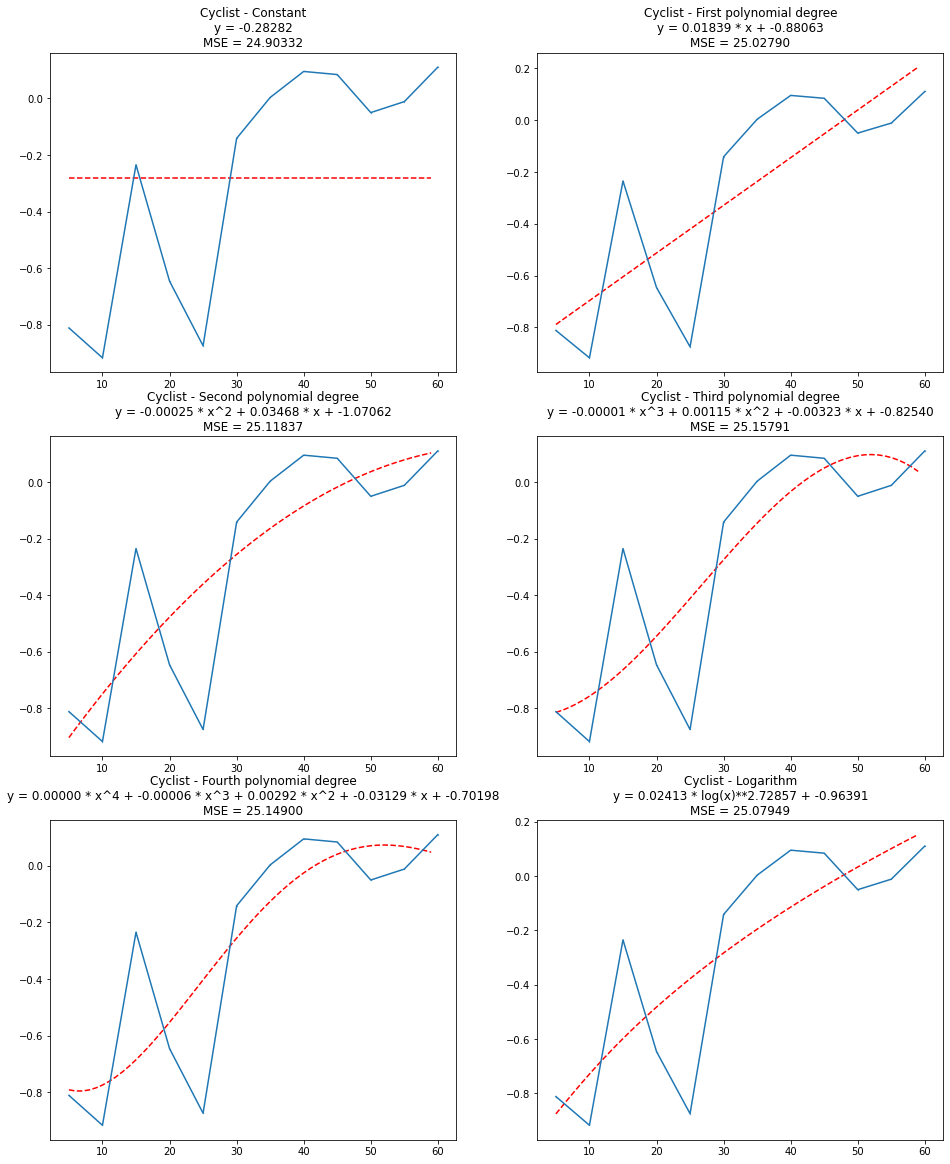

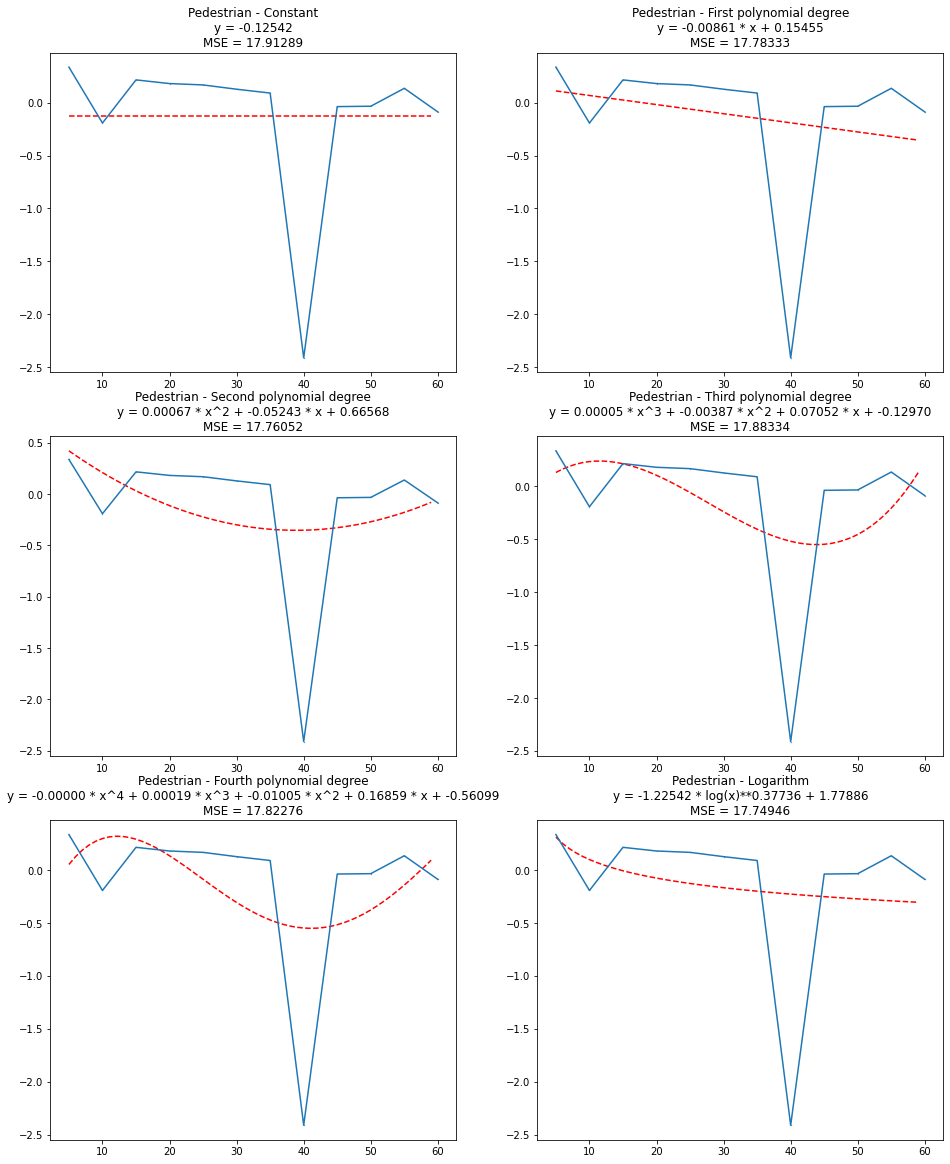

In [67]:
popt_car = None
popt_cyclist = None
popt_pedestrian = None

for class_name in ['Car', 'Cyclist', 'Pedestrian']:
    plt.figure(figsize=(16, 20))

    Y = dict_class_median[class_name]
    X = list(range(5,65,5))

    Y_val = df_val[df_val['type'] == class_name]
    Y_val = Y_val['distance']-Y_val['distance_approx_2'].values
    X_val = df_val[df_val['type'] == class_name]['distance_approx_2'].values

    def objective_const(x, a):
        return a

    def objective_f(x, a, b):
        return a * x + b

    def objective_2f(x, a, b, c):
        return a * x**2 + b * x + c

    def objective_3f(x, a, b, c, d):
        return a * x**3 + b * x**2 + c * x + d

    def objective_4f(x, a, b, c, d, e):
        return a * x**4 + b * x**3 + c * x**2 + d * x + e

    def objective_log_f(x, a, b, c):
        return a * np.log(x)**b + c 

    functions = [objective_const, objective_f, objective_2f, objective_3f, objective_4f, objective_log_f]
    titles = [class_name+' - Constant\ny = %.5f\nMSE = %.5f',
              class_name+' - First polynomial degree\ny = %.5f * x + %.5f\nMSE = %.5f',
              class_name+' - Second polynomial degree\ny = %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
              class_name+' - Third polynomial degree\ny = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
              class_name+' - Fourth polynomial degree\ny = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f',
              class_name+' - Logarithm\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f']

    for i in range(6):
        plt.subplot(3, 2, i+1)
        function = functions[i]
        popt, _ = curve_fit(function, X, Y, maxfev = 1000)
        
        if class_name == 'Car' and functions[i] == objective_2f:
            popt_car = popt
        elif functions[i] == objective_const:
            if class_name == 'Pedestrian':
                popt_pedestrian = popt
            elif class_name == 'Cyclist':
                popt_cyclist = popt
            
        plt.scatter(X, Y, s=0.1)
        X_line = np.arange(min(X), max(X), 1)
        Y_line = list(map(lambda x: functions[i](x, *popt), X_line))
        plt.plot(X_line, Y_line, '--', color='red')
        Y_pred = function(X_val, *popt)
        if type(Y_pred) != np.ndarray:
            Y_pred = [Y_pred]*len(X_val)
        mse = mean_squared_error(Y_val, Y_pred)
        plt.plot(X, Y)
        plt.title(titles[i] % (*popt, mse))
    plt.show()

Second polynomial degree - Car\
Constant - Cyclist & Pedestrian

In [68]:
pc_proj_refinement_model = Regression_model_class(Regression_model(objective_2f, popt_car),
                                                  Regression_model(objective_const, popt_pedestrian),
                                                  Regression_model(objective_const, popt_cyclist))
print(pc_proj_refinement_model)

car: {function = <function objective_2f at 0x7fa1ec2e3598>, variables = [-2.18875583e-04  2.37292576e-02  1.23104587e+00]} 
pedestrian: {function = <function objective_const at 0x7fa1ec2c57b8>, variables = [-0.12542462]} 
cyclist: {function = <function objective_const at 0x7fa1ec2c57b8>, variables = [-0.28281803]}



In [69]:
with open('pc_proj_refinement_model.pkl', 'wb') as f:
    f.write(pickle.dumps(pc_proj_refinement_model))

## MSE of the distance with the 2nd method by KITTI difficulties and classes applying distance rectification without outliers.

In [70]:
def get_types(image_id):
    df_frame = df[df['frame'] == image_id]
    types = list(df_frame['type'])
    return types

In [71]:
def approximate_distance(image_id, model):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    types = df[df['frame'] == image_id]['type'].tolist()
    incomplete = df[df['frame'] == image_id]['incomplete_2d_horizontal'].tolist()
    
    # Sort bbs by height (change to sort by regression method using height)
    with open('height_model.pkl', 'rb') as f:
        height_model = pickle.load(f)
        id_bbs = sorted(list(range(len(bbs))),
                     key=lambda i: approximate_distance_height(types[i], bbs[i][1], bbs[i][3],
                                                        not incomplete[i], height_model))
        bbs = list(enumerate(bbs))
        types = list(enumerate(types))
        bbs.sort(key=lambda x: id_bbs.index(x[0]))
        types.sort(key=lambda x: id_bbs.index(x[0]))
        bbs = list(map(lambda x: x[1], bbs))
        types = list(map(lambda x: x[1], types))
        
    # Create output dict
    bbs_distance = {'frame':[image_id]*len(types),
                    'left':list(map(lambda x: x[0], bbs)),
                    'top':list(map(lambda x: x[1], bbs)),
                    'right':list(map(lambda x: x[2], bbs)),
                    'bottom':list(map(lambda x: x[3], bbs)),
                    'type':types,
                    'distance':[]}
    
    # Iterate over bb
    for type_name, bb in zip(types, bbs):
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            # Approximate distance
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            height = bb[3] - bb[1] # bottom - top
            if type_name == 'Car':
                f = model.car.function
                rectification = f(distance, *model.car.variables)
                distance += rectification
            elif type_name == 'Pedestrian':
                f = model.pedestrian.function
                rectification = f(distance, *model.pedestrian.variables)
                distance += rectification
            elif type_name == 'Cyclist':
                f = model.cyclist.function
                rectification = f(distance, *model.cyclist.variables)
                distance += rectification
            else:
                print("Type must be Car, Pedestrian or Cyclist")
            
            bbs_distance['distance'].append(distance)
        else:
            bbs_distance['distance'].append(-1)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_distance

In [72]:
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
distance_approx = {'frame':[], 'left':[], 'top':[], 'right':[], 'bottom':[], 'type':[], 'distance':[]}
for frame in df['frame'].unique():
    frame_approx = approximate_distance(frame, pc_proj_refinement_model)
    dict_items = ['frame','left','top','right','bottom','type','distance']
    for item in dict_items:
        distance_approx[item].extend(frame_approx[item])
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = dict_items[:-1]+['distance_approx_2_rect_2'],
                         data = list(zip(distance_approx['frame'], distance_approx['left'],
                                         distance_approx['top'], distance_approx['right'],
                                         distance_approx['bottom'], distance_approx['type'],
                                         distance_approx['distance'])))

100%|██████████| 7481/7481 [02:39<00:00, 45.04it/s]

In [73]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])

In [74]:
df_val

frame  id        type  truncated  occluded  alpha    left     top  \
0      5984   0         Car        0.0       1.0   3.10  431.50  171.26   
1      5984   1  Pedestrian        0.0       1.0   2.84  759.60  163.84   
2      5984   2         Car        0.0       0.0   1.22  699.42  157.64   
3      5984   3         Car        0.0       1.0  -2.01  729.47  164.21   
4      5984   4         Car        0.0       0.0  -2.05  767.91  164.74   
...     ...  ..         ...        ...       ...    ...     ...     ...   
6696   7480   9         Car        0.0       2.0  -0.33  749.78  170.88   
6697   7480  10         Car        0.0       1.0  -2.90  344.07  180.05   
6698   7480  11         Car        0.0       2.0  -2.91  382.70  179.71   
6699   7480  12         Car        0.0       0.0  -1.69  631.71  179.85   
6700   7480  13         Car        0.0       2.0  -1.62  619.92  176.90   

       right  bottom  height  width  length      x     y      z    ry  \
0     514.83  204.10    1.49   1.46    3.84  -6.60  1.44  34.58  2.91   
1     772.27  193.28    1.86   0.57    1.08   9.91  1.30  46.20  3.05   
2     744.58  190.94    2.21   1.76    4.11   7.73  1.22  50.24  1.37   
3     774.61  189.74    1.75   1.57    4.07  10.11  1.18  51.72 -1.82   
4     823.24  187.41    1.54   1.71    5.03  13.25  1.02  51.91 -1.80   
...      ...     ...     ...    ...     ...    ...   ...    ...   ...   
6696  917.51  243.48    1.77   1.69    3.82   5.72  1.75  18.85 -0.04   
6697  479.10  224.15    1.49   1.59    4.44  -7.12  1.78  26.03  3.12   
6698  495.48  219.10    1.48   1.63    4.10  -6.79  1.78  28.78 -3.14   
6699  678.40  214.37    1.41   1.56    4.08   1.90  1.74  31.98 -1.63   
6700  647.01  199.92    1.43   1.58    3.37   1.47  1.71  47.02 -1.59   

       distance  height_image  width_image  theta_ray  \
0     35.233649         32.84        83.33      -0.19   
1     47.268786         29.44        12.67       0.21   
2     50.845835         33.30        45.16       0.15   
3     52.712075         25.53        45.14       0.19   
4     53.584055         22.67        55.33       0.25   
...         ...           ...          ...        ...   
6696  19.776334         72.60       167.73       0.29   
6697  27.044846         44.10       135.03      -0.26   
6698  29.623654         39.39       112.78      -0.23   
6699  32.083610         34.52        46.69       0.06   
6700  47.074042         23.02        27.09       0.03   

      incomplete_2d_horizontal  incomplete_2d_bottom  distance_approx_2  \
0                        False                 False          33.951394   
1                        False                 False          46.418030   
2                        False                 False          49.005706   
3                        False                 False          50.347864   
4                        False                 False          51.782106   
...                        ...                   ...                ...   
6696                     False                 False          19.033945   
6697                     False                 False          25.222057   
6698                     False                 False          29.558852   
6699                     False                 False          30.272493   
6700                     False                 False          46.099539   

      distance_error  difficulty  distance_approx_2_rect_1  \
0           1.282255           1                 36.282274   
1           0.850756           1                 41.398467   
2           1.840128           1                 50.413607   
3           2.364212           1                 51.623465   
4           1.801950           3                 52.907280   
...              ...         ...                       ...   
6696        0.742389           2                 21.263338   
6697        1.822789           1                 27.616310   
6698        0.064803           2                 31.964913   
6699        1.811117  

In [75]:
difficulties = [0, 1, 2]                       
classes = ["Car","Cyclist","Pedestrian"]
text_difficulties = ["Easy", "Moderate", "Hard"]

# Create loading bar
n_frames = 0
for difficulty in range(3):
    for class_name in classes:
        n_frames += len(df_val[(df_val['difficulty'] <= difficulty) & \
                                  (df_val['type'] == class_name)]['frame'].unique())
loading_bar = tqdm(total=n_frames, position=0, leave=True)

def mse(frame):
    df_frame = df_val[df_val['frame'] == frame]
    bbs_distance_gt = df_frame['distance'].tolist()
    bbs_distance_approx = df_frame['distance_approx_2_rect_2'].tolist()
    mse_value = mean_squared_error(bbs_distance_gt, bbs_distance_approx)
    
    # Update loading bar
    loading_bar.update(1)
    
    return mse_value

# Iterate over difficulties
for difficulty, text_difficulty in zip(difficulties, text_difficulties):
    # Iterate over classes
    for class_name in classes:                  
        df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
        mse_by_frame = df_difficulty['frame'].unique()
        start_time = time.time()
        mse_by_frame = list(map(mse, mse_by_frame))

        mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))

        mean_mse = statistics.mean(mse_by_frame_without_none)
        print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

        print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mean_mse))

 22%|██▏       | 1021/4575 [00:00<00:02, 1674.65it/s]

--- 0.5014073848724365 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 157.00806945765277

--- 0.05894112586975098 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 128.52675705003205

--- 0.1380143165588379 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 56.78447741595187



 60%|█████▉    | 2737/4575 [00:01<00:01, 1711.19it/s]

--- 0.7179224491119385 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 142.59720441074523

--- 0.08392930030822754 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 139.28044086709573



 67%|██████▋   | 3083/4575 [00:01<00:00, 1713.57it/s]

--- 0.175079345703125 seconds to calculate MSE, Moderate difficulty, Pedestrian class  ---

Mean of all MSE by frame, Moderate difficulty, Pedestrian class = 73.6449576049695



 94%|█████████▍| 4312/4575 [00:02<00:00, 1716.25it/s]

--- 0.7068705558776855 seconds to calculate MSE, Hard difficulty, Car class  ---

Mean of all MSE by frame, Hard difficulty, Car class = 142.2993145839417

--- 0.09244132041931152 seconds to calculate MSE, Hard difficulty, Cyclist class  ---

Mean of all MSE by frame, Hard difficulty, Cyclist class = 135.0036433431658



 98%|█████████▊| 4484/4575 [00:02<00:00, 1695.91it/s]

--- 0.1979846954345703 seconds to calculate MSE, Hard difficulty, Pedestrian class  ---

Mean of all MSE by frame, Hard difficulty, Pedestrian class = 84.81890402625933



100%|██████████| 4575/4575 [00:19<00:00, 1695.91it/s]